In [1]:
# Installation of any non native supported libraries

# !pip install beautifulsoup4
# !pip install wget
# !pip install praw
# !pip install vaderSentiment

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import wget
import os
import re 
import openpyxl
import pandas as pd
from datetime import datetime
import calendar
from pyjstat import pyjstat

import seaborn as sns; 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import praw
from praw.models import MoreComments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import scipy.stats as stats
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro

from sklearn.linear_model import LinearRegression

In [3]:
# Notebook settings
pd.set_option('display.max_rows', None) # Allows observation of rows without any limitations
pd.set_option('display.max_columns', None) # Allows observation of columns without any limitations

In [2]:
# Your local download directory
download_destination = '/Users/dorin/Documents/Jupyter Notebook Files/CCT - Masters/MSc_Data_Analytics_CA2/Data'

## Download Data

In [3]:
# Your local download directory
download_destination = '/Users/dorin/Documents/Jupyter Notebook Files/CCT - Masters/MSc_Data_Analytics_CA2/Data'

### IE Monthly Statistics of Building Materials and Components

In [4]:
api = 'https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/WPM28/JSON-stat/2.0/en/'

# read from json-stat
dataset = pyjstat.Dataset.read(api)

# write to dataframe
df = dataset.write('dataframe')
df = df[df['Statistic'] == 'Wholesale Price Index (Excl VAT) for Building and Construction Materials']
ie_df = df.drop(['Statistic'], axis=1)
ie_df = ie_df.groupby(['Month','Type of Material'], sort=False)['value'].mean().unstack()
ie_df.to_csv(download_destination + '/IE Data/IE_Building_Materials_CostIndex_Compiled.csv')

### UK Monthly Statistics of Building Materials and Components

In [179]:
Downloaded_data = []

# Current Date - store record of today's month and year
current_date = datetime.today() 
current_year, current_month = int(current_date.strftime('%Y')), int(current_date.strftime('%m'))
current_month = current_month - 2 # Account for delay uploading data by data.gov.uk


while current_year >= 2018:
    # Webpage
    URL = 'https://www.data.gov.uk/dataset/75ee36ed-21f7-4d7b-9e7c-f5bf4546145d/monthly-statistics-of-building-materials-and-components'
    r = requests.get(URL) # get the link
    soup = BeautifulSoup(r.content, "html.parser")
    file_name = '{}/UK Data/{} {} UK Monthly Statistics of Building Materials and Components.xlsx'.format(download_destination, current_year,calendar.month_name[current_month])
    print('{} {}'.format(current_year, calendar.month_name[current_month]))
    
    for a in soup.find_all("a", href=lambda href: href.lower() and str(current_year).lower() in href and str(calendar.month_name[current_month]).lower() in href.lower()):
        l = a['href']
        
    if not l.endswith('.xlsx'): # if link isnt an excel spreadsheet then continue search with new link = l
        r = requests.get(l) 
        soup = BeautifulSoup(r.content, "html.parser")
        for a in soup.find_all("a", href=lambda href: href.lower() and str(current_year).lower() in href and str(calendar.month_name[current_month]).lower() in href.lower() and '.xlsm' in href.lower(), limit=1):
            l = a['href']
            
    # Download link
    print(l)
    r = requests.get(l) 
    with open(file_name, 'wb') as f:
        f.write(r.content)     # Save files to download destination
    Downloaded_data.append(file_name)
    
    current_year = current_year - 1 # loop to next year
    
print('')
print('100% |■■■■■■■■■■■■■■■■■■■■■■■■■■■|')
print('Total files downloaded: ' + str(len(Downloaded_data)))

2023 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1148775/23-cs4-_Construction_Building_Materials_-_Tables_March_2023.xlsx
2022 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1065392/22-cs4_-_Construction_Building_Materials_-_Tables_March_2022.xlsx
2021 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/976157/21-cs4_-_Construction_Building_Materials_-_Tables_March_2021.xlsm
2020 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/876765/20-cs4_-_Construction_Building_Materials_-_Tables_March_2020.xlsm
2019 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/791320/19-cs4_-_Construction_Building_Materials_-_Excel_Tables_March_2019.xlsm
2018 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachm

In [653]:
# Creating Empty DataFrame for storing compiled data
UK_Data_Masterfile = pd.DataFrame()
UK_Data_Masterfile.to_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv')

In [654]:
current_year = 2023
for wb in Downloaded_data:
    #print('{} {}'.format(current_year, calendar.month_name[current_month]))

    wb = openpyxl.load_workbook(wb) # open spreadsheet
    sheets = wb.sheetnames 
    ws = wb[sheets[3]] # third excel sheet has monthly data
    df = pd.DataFrame(ws.values) # pandas read information as dataframe

    # Set the sixth row as index - useful later for keeping months as column labels and dropping null columns
    df = df.T.set_index(6).T 
    df.columns.values[0] = 'Materials' # rename first column
    df = df.drop([col for col in df.columns.values if not col], axis=1) # Delete Null Columns
    mat = df.loc[df.iloc[:,0].values != None] # Return all the rows which dont have null values
    mat = mat['Materials'].values
    mat = mat[4:49] # Drop extra headers from top and bottom of excel spreadsheet
    mat = [w for w in mat if not w.isupper() or w.isdigit()] # Remaining headers are in uppercase so we can easily drop them
    df = df[df['Materials'].isin(mat)] # return dataframe filtered with no headers or null values
    df.reset_index(drop=True, inplace=True) # Reset the index 
    df.columns.name = 'Index' # rename index column's name - not necessary but easy to understand when looking at df
    if current_year <= 2020: # Files older than 2021 had a different format, need to account for extra filler rows
        rows_to_delete = [0,1]
        df = df.drop(index=rows_to_delete)
        df1 = df.copy()
        df.iloc[0,:],df.iloc[1,:]= df1.iloc[1,:],df1.iloc[0,:]
        df.reset_index(drop=True, inplace=True) # Reset the index

    # Take all column headers and format them correctly to : YYYY-MM
    curr_month = current_month
    curr_year = current_year
    col_list = [col for col in df.columns[::-1]]
    new_col = []
    for c in col_list[:-1]:
        curr_month = curr_month - 1
        if curr_month == 0:
            curr_year = curr_year - 1
            curr_month = 12  
        c = str(curr_year) + ' ' + calendar.month_name[curr_month]
        new_col.append(c)    
    new_col.append('Materials') 
    new_col.reverse()
    df.columns = new_col
    
    # Outer merge to append the first year's data
    if current_year == 2023:
        UK_Data_Masterfile = pd.read_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv', index_col=0)
        new_df = pd.merge(df, UK_Data_Masterfile, left_index=True, right_index=True, how='outer')
        new_df.to_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv')
    else:
        # Update Masterfile using merge to append new data
        # inner merge to append new information, any duplicates will take the suffixes and '_y' is dropped
        UK_Data_Masterfile = pd.read_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv', index_col=0)
        new_df = pd.merge(df, UK_Data_Masterfile, left_index=True, right_index=True, how='inner', suffixes=('', '_y'))
        new_df = new_df.drop(new_df.filter(regex='_y$').columns, axis=1)
        new_df.to_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv')
    current_year = current_year - 1

2023 March
2022 March
2021 March
2020 March
2019 March
2018 March


## Data Preperation

### Irish Data

In [4]:
# Custom list with possible missing value formats
missing_value_formats = ["n.a.","?","NA" ,"Na", "n/a", "na", "--","N.A.","NaN", "None", "Null"]

ie_df = pd.read_csv(download_destination + '/IE Data/IE_Building_Materials_CostIndex_Compiled.csv', index_col = 0, na_values = missing_value_formats)
ie_df

Materials  Stone, sand and gravel  Sand and gravel  Stone  \
Month                                                                      
2015 January        99.2                    95.7             98.0   95.3   
2015 February       99.0                    93.9             96.1   93.5   
2015 March          99.5                    98.1             97.5   98.2   
2015 April          99.8                    99.9            106.2   98.7   
2015 May           100.2                   100.5            103.1  100.0   
...                  ...                     ...              ...    ...   
2022 November      142.8                   116.4            131.1  113.5   
2022 December      142.9                   123.3            133.0  121.3   
2023 January       143.7                   120.9            131.0  118.8   
2023 February      144.0                   121.5            128.7  120.1   
2023 March         143.8                   120.9            120.9  120.9   

               Cement  Ready mixed mortar and concrete  \
Month                                                    
2015 January    100.0                            101.6   
2015 February   100.0                            100.4   
2015 March      100.0                            100.1   
2015 April      100.0                             99.8   
2015 May        100.0                             99.6   
...               ...                              ...   
2022 November   168.6                            146.0   
2022 December   168.6                            142.2   
2023 January    168.6                            144.6   
2023 February   168.6                            143.4   
2023 March      168.6                            143.7   

               Concrete blocks and bricks  \
Month                                       
2015 January                        100.2   
2015 February                       100.6   
2015 March                           99.0   
2015 April                           99.3   
2015 May                             99.4   
...                                   ...   
2022 November                       128.7   
2022 December                       129.6   
2023 January                        129.2   
2023 February                       130.0   
2023 March                          131.5   

               Other concrete products including precast  \
Month                                                      
2015 January                                        99.2   
2015 February                                       99.3   
2015 March                                          99.3   
2015 April                                          99.3   
2015 May                                            99.7   
...                                                  ...   
2022 November                                      128.1   
2022 December                                      128.9   
2023 January                                       129.9   
2023 February                                      129.9   
2023 March                                         129.9   

               Other concrete products (excluding precast concrete)  \
Month                                                                 
2015 January                                                99.4      
2015 February                                               99.4      
2015 March                                                  99.4      
2015 April                                                  99.4      
2015 May                                                    99.4      
...                                                          ...      
2022 November                                              125.8      
2022 December                                              125.8      
2023 January                                               124.2      
2023 February                                                NaN      
2023 March                                          

In [5]:
# Calculating percentage of missing data
quantity_missing = ie_df.isnull().sum(axis=0)
percent_missing = ie_df.isnull().sum(axis=0)/ len(ie_df)
missing_value_data = pd.DataFrame({'Quantity_missing': quantity_missing, 'Percentage_missing': percent_missing})
missing_value_data['Percentage_missing'] = missing_value_data['Percentage_missing'].map(lambda n: '{:,.2%}'.format(n))
missing_value_data

Quantity_missing  \
Materials                                                          0   
Stone, sand and gravel                                             0   
Sand and gravel                                                    0   
Stone                                                              0   
Cement                                                             0   
Ready mixed mortar and concrete                                    0   
Concrete blocks and bricks                                         0   
Other concrete products including precast                          0   
Other concrete products (excluding precast conc...                 2   
Precast concrete                                                   2   
Structural steel and reinforcing metal                             0   
Structural steel                                                   0   
Other structural steel                                             0   
Structural steel fabricated metal                                  0   
Reinforcing metal                                                  0   
Other steel products                                               0   
Rough timber (including plain sawn)                                0   
Rough timber (softwood)                                            0   
Rough timber (hardwood)                                            0   
Machined, treated engineered timber                                0   
Other treated timber                                               0   
Wooden windows and doors                                           0   
Bituminous macadam, asphalt and bituminous emul...                 0   
Bituminous macadam and asphalt                                     0   
Bituminous emulsions                                               0   
Electrical fittings                                                0   
Lighting equipment                                                 0   
Protection and communication equipment                             0   
All other materials                                                0   
Plumbing materials including sanitary ware                         0   
HVAC (heating and ventilation equipment)                           0   
Insulating materials                                               0   
Pipes and fittings                                                 0   
PVC pipes and fittings                                             0   
Copper pipes and fittings                                          0   
Plaster                                                            0   
Paints, oils and varnishes                                         0   
Glass                                                              0   
All other metal fittings                                           0   
All other products                                                 0   

                                                   Percentage_missing  
Materials                                                       0.00%  
Stone, sand and gravel                                          0.00%  
Sand and gravel                                                 0.00%  
Stone                                                           0.00%  
Cement                                                          0.00%  
Ready mixed mortar and concrete                                 0.00%  
Concrete blocks and bricks                                      0.00%  
Other concrete products including precast                       0.00%  
Other concrete products (excluding precast conc...              2.02%  
Precast concrete                                                2.02%  
Structural steel and reinforcing metal                          0.00%  
Structural steel                                                0.00%  
Other structural steel                                          0.00%  
Structural steel fabricated metal                               0.00%  
Reinforcing metal  

<Figure size 1800x600 with 0 Axes>

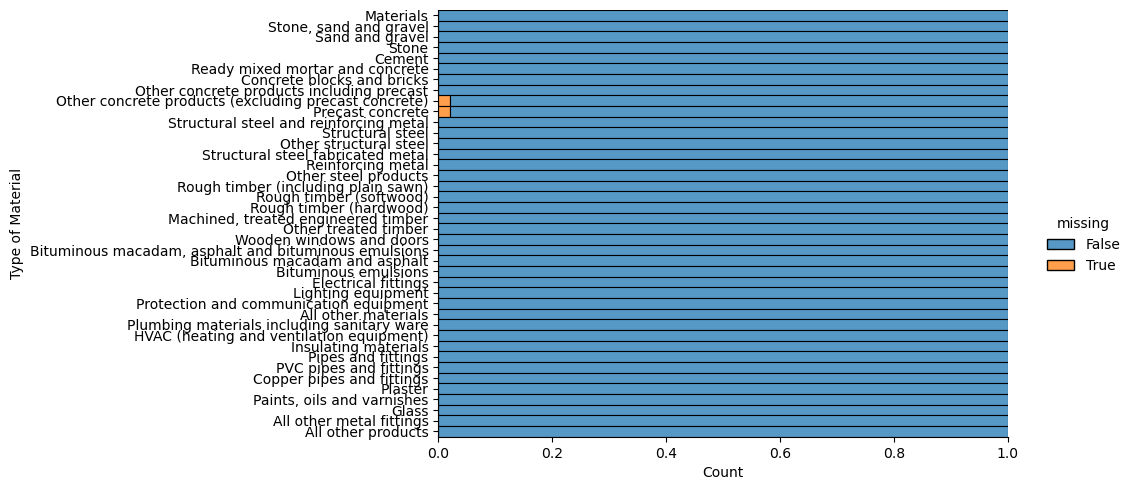

In [6]:
# seaborn visualisation
plt.figure(figsize=(18,6)) # setting figure size

ie_df.columns.name = 'Type of Material' # Assign the headers a name to reference in the plot

sns.displot( 
    data=ie_df.isna().melt(value_name="missing"), # indicating if missing value is true
    y='Type of Material',
    hue="missing",
    multiple="fill",
    aspect=2.1
);

In [7]:
# Locating where the missing values are within the dataset
ie_df[ie_df.isna().any(axis=1)]

Type of Material  Materials  Stone, sand and gravel  Sand and gravel  Stone  \
Month                                                                         
2023 February         144.0                   121.5            128.7  120.1   
2023 March            143.8                   120.9            120.9  120.9   

Type of Material  Cement  Ready mixed mortar and concrete  \
Month                                                       
2023 February      168.6                            143.4   
2023 March         168.6                            143.7   

Type of Material  Concrete blocks and bricks  \
Month                                          
2023 February                          130.0   
2023 March                             131.5   

Type of Material  Other concrete products including precast  \
Month                                                         
2023 February                                         129.9   
2023 March                                            129.9   

Type of Material  Other concrete products (excluding precast concrete)  \
Month                                                                    
2023 February                                                   NaN      
2023 March                                                      NaN      

Type of Material  Precast concrete  ...  \
Month                               ...   
2023 February                  NaN  ...   
2023 March                     NaN  ...   

Type of Material  HVAC (heating and ventilation equipment)  \
Month                                                        
2023 February                                        118.0   
2023 March                                           118.0   

Type of Material  Insulating materials  Pipes and fittings  \
Month                                                        
2023 February                    130.3               146.7   
2023 March                       130.3               146.5   

Type of Material  PVC pipes and fittings  Copper pipes and fittings  Plaster  \
Month                                                                          
2023 February                      164.8                      140.9    204.7   
2023 March                         163.7                      140.9    205.4   

Type of Material  Paints, oils and varnishes  Glass  All other metal fittings  \
Month                                                                           
2023 February                          156.0  104.7                     117.4   
2023 March                             156.0  104.7                     117.4   

Type of Material  All other products  
Month                                 
2023 February                  127.2  
2023 March                     126.4  

[2 rows x 40 columns]

In [8]:
ie_df.ffill(inplace = True) ## Using ffill it will take the previous rows data to fill in the missing info

In [9]:
# Checking all missing data was filled
ie_df[ie_df.isna().any(axis=1)]

Empty DataFrame
Columns: [Materials, Stone, sand and gravel, Sand and gravel, Stone, Cement, Ready mixed mortar and concrete, Concrete blocks and bricks, Other concrete products including precast, Other concrete products (excluding precast concrete), Precast concrete, Structural steel and reinforcing metal, Structural steel, Other structural steel, Structural steel fabricated metal, Reinforcing metal, Other steel products, Rough timber (including plain sawn), Rough timber (softwood), Rough timber (hardwood), Machined, treated engineered timber, Other treated timber, Wooden windows and doors, Bituminous macadam, asphalt and bituminous emulsions, Bituminous macadam and asphalt, Bituminous emulsions, Electrical fittings, Lighting equipment, Protection and communication equipment, All other materials, Plumbing materials including sanitary ware, HVAC (heating and ventilation equipment), Insulating materials, Pipes and fittings, PVC pipes and fittings, Copper pipes and fittings, Plaster, Paints, oils and varnishes, Glass, All other metal fittings, All other products]
Index: []

[0 rows x 40 columns]

In [10]:
duplicate_rows_df = ie_df[ie_df.duplicated()] # discovering duplicated rows
print("Number of duplicated rows in Irish dataset: ", len(duplicate_rows_df))

Number of duplicated rows in Irish dataset:  0


</br>

### UK Data

In [11]:
# Custom list with possible missing value formats
missing_value_formats = ["n.a.","?","NA" ,"Na", "n/a", "na", "--","N.A.","NaN", "None", "Null", 'c', 'C']

uk_df = pd.read_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv', index_col = 0, na_values = missing_value_formats)
uk_df

Materials    2017 February  \
0                                         - exclud...              127   
1            Sand & gravel           - including levy            121.7   
2               Coated roadstone     - excluding levy            113.2   
3                                             Cement             119.9   
4                             Ready-mixed concrete **            118.7   
5                          Pre-cast concrete products            119.4   
6           of which : Blocks, bricks, tiles  & fl...            123.7   
7                   Concrete reinforcing bars (steel)             92.7   
8                                         All Bricks             121.2   
9                                     Ceramic tiles *             c      
10                               Ceramic sanitaryware             c      
11                    Imported sawn or planed wood               106.3   
12                                   Imported plywood            108.1   
13                                       Sawn wood **            108.4   
14                                  Particle Board **            137.5   
15                               Builders woodwork **            115.4   
16                      of which : Doors & windows **            116.9   
17                        Fabricated structural steel             95.2   
18                                 Doors & windows **            119.4   
19                                       Screws etc *             c      
20                      Other builders' ironmongery**            115.1   
21                          Central heating boilers *             c      
22                   Taps and Valves for sanitaryware             c      
23                                Metal Sanitaryware*              109   
24                      Pipes and fittings (rigid) **            113.4   
25                   Pipes and fittings (flexible) **            110.6   
26                                    Sanitaryware **            114.1   
27                                 Doors & windows **              116   
28                                 Asphalt products *             92.9   
29         Insulating materials (thermal or acoustic)            123.4   
30                                    Paint (aqueous)            112.3   
31                               Paint (non-aqueous)             120.8   
32                   Lighting equipment for buildings             c      
33                    Lighting equipment for roads **             98.3   
34                         Electric heating apparatus            101.9   
35                           Electric water heaters *            120.5   
36                                 Kitchen furniture               112   

         2017 March       2017 April         2017 May        2017 June  \
0             126.9            126.6            126.2            124.1   
1             121.7            121.6            121.7            121.3   
2             113.2            113.2            113.2            113.2   
3             120.5            119.6            117.6            117.6   
4             117.7            117.9            118.3            119.4   
5               120              120            120.9            121.2   
6             124.6            124.7            125.9            126.4   
7              92.9               93             91.3             90.1   
8             120.4            121.6            122.3            123.8   
9              c                c                c                c      
10             c                c                c                c      
11            106.6              108            107.7            108.2   
12              109            106.8            105.7            107.5   
13            110.2            110.4            110.6            112.3   
14            137.5            138.7            138.7            139.7   
15            116.3            116.5           

In [12]:
cols = uk_df.columns.drop('Materials') # Select every feature except Materials
uk_df[cols] = uk_df[cols].apply(pd.to_numeric,errors='coerce') # Convert to numeric, any Null data will be converted to NaN
df_melted = uk_df.melt(id_vars=['Materials']) # Using Melt we can reformat the dataframe
df_melted.columns = df_melted.columns.str.replace('variable', 'Month') # Rename feature from variable to Month
df_melted.columns = df_melted.columns.str.replace('Materials', 'Type of Material') # Rename Materials feature to match Irish Dataset
df_melted

Type of Material          Month  value
0                                           - exclud...  2017 February  127.0
1              Sand & gravel           - including levy  2017 February  121.7
2                 Coated roadstone     - excluding levy  2017 February  113.2
3                                               Cement   2017 February  119.9
4                               Ready-mixed concrete **  2017 February  118.7
...                                                 ...            ...    ...
2696                   Lighting equipment for buildings  2023 February    NaN
2697                    Lighting equipment for roads **  2023 February    NaN
2698                         Electric heating apparatus  2023 February    NaN
2699                           Electric water heaters *  2023 February  110.9
2700                                 Kitchen furniture   2023 February  148.2

[2701 rows x 3 columns]

In [13]:
# Reshape the dataframe into the same format matching the Irish dataset
uk_df = df_melted.groupby(['Month','Type of Material'], sort=False)['value'].mean().unstack()
uk_df

Type of Material                                        - excluding levy  \
Month                                                                      
2017 February                                                 127.0        
2017 March                                                    126.9        
2017 April                                                    126.6        
2017 May                                                      126.2        
2017 June                                                     124.1        
...                                                             ...        
2022 October                                                  136.9        
2022 November                                                 142.7        
2022 December                                                 142.7        
2023 January                                                  142.5        
2023 February                                                 141.7        

Type of Material      Sand & gravel           - including levy  \
Month                                                            
2017 February                                            121.7   
2017 March                                               121.7   
2017 April                                               121.6   
2017 May                                                 121.7   
2017 June                                                121.3   
...                                                        ...   
2022 October                                             161.5   
2022 November                                            164.0   
2022 December                                            164.0   
2023 January                                             164.0   
2023 February                                            164.0   

Type of Material      Coated roadstone     - excluding levy       Cement   \
Month                                                                       
2017 February                                         113.2         119.9   
2017 March                                            113.2         120.5   
2017 April                                            113.2         119.6   
2017 May                                              113.2         117.6   
2017 June                                             113.2         117.6   
...                                                     ...           ...   
2022 October                                          141.7         132.6   
2022 November                                         139.5         134.4   
2022 December                                         139.5         138.3   
2023 January                                          140.1         143.3   
2023 February                                         139.9         143.6   

Type of Material       Ready-mixed concrete **  \
Month                                            
2017 February                            118.7   
2017 March                               117.7   
2017 April                               117.9   
2017 May                                 118.3   
2017 June                                119.4   
...                                        ...   
2022 October                             132.1   
2022 November                            134.3   
2022 December                            136.0   
2023 January                             137.0   
2023 February                            137.0   

Type of Material       Pre-cast concrete products  \
Month                                               
2017 February                               119.4   
2017 March                                  120.0   
2017 April                                  120.0   
2017 May                                    120.9   
2017 June                                   121.2   
...                                           ...   
2022 October                                168.1   
2022 November         

In [14]:
# Calculating percentage of missing data
quantity_missing = uk_df.isnull().sum(axis=0)
percent_missing = uk_df.isnull().sum(axis=0)/ len(uk_df)
missing_value_data = pd.DataFrame({'Quantity_missing': quantity_missing, 'Percentage_missing': percent_missing})
missing_value_data['Percentage_missing'] = missing_value_data['Percentage_missing'].map(lambda n: '{:,.2%}'.format(n))

missing_value_data[missing_value_data['Percentage_missing'].str.rstrip('%').astype('float') > 0] 
# View missing uk data above 5% which will have meaningful impact on final results within ML models

Quantity_missing  \
Type of Material                                                       
                                      - excludi...                 5   
     Concrete reinforcing bars (steel)                             1   
     All Bricks                                                   65   
     Ceramic tiles *                                              43   
     Ceramic sanitaryware                                         73   
     Sawn wood **                                                 62   
     Particle Board **                                            25   
     Fabricated structural steel                                   1   
     Screws etc *                                                  8   
     Central heating boilers *                                     8   
     Taps and Valves for sanitaryware                             16   
     Asphalt products *                                           65   
     Lighting equipment for buildings                             73   
     Lighting equipment for roads **                              58   
     Electric heating apparatus                                   43   

                                                   Percentage_missing  
Type of Material                                                       
                                      - excludi...              6.85%  
     Concrete reinforcing bars (steel)                          1.37%  
     All Bricks                                                89.04%  
     Ceramic tiles *                                           58.90%  
     Ceramic sanitaryware                                     100.00%  
     Sawn wood **                                              84.93%  
     Particle Board **                                         34.25%  
     Fabricated structural steel                                1.37%  
     Screws etc *                                              10.96%  
     Central heating boilers *                                 10.96%  
     Taps and Valves for sanitaryware                          21.92%  
     Asphalt products *                                        89.04%  
     Lighting equipment for buildings                         100.00%  
     Lighting equipment for roads **                           79.45%  
     Electric heating apparatus                                58.90%

<Figure size 1800x600 with 0 Axes>

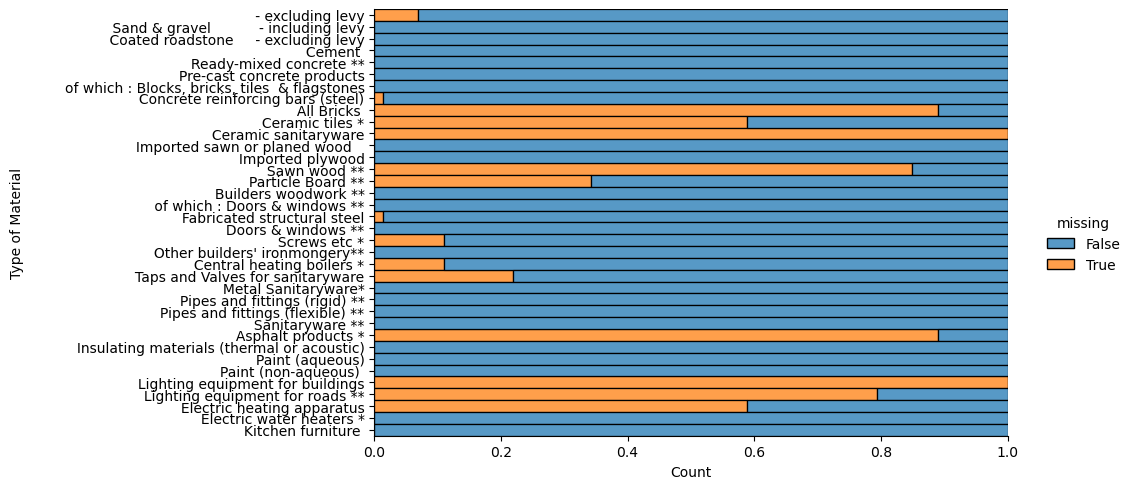

In [15]:
# seaborn visualisation
plt.figure(figsize=(18,6)) # setting figure size

sns.displot( 
    data=uk_df.isna().melt(value_name="missing"), # indicating if missing value is true
    y='Type of Material',
    hue="missing",
    multiple="fill",
    aspect=2.1
);

In [16]:
# It is apparent that the feature headers have many blank spaces within the names.
uk_df.columns = uk_df.columns.str.strip()
uk_df.columns
# To make it easier to call features by their names, blank spaces at beginning and end of strings will be removed

Index(['- excluding levy', 'Sand & gravel           - including levy',
       'Coated roadstone     - excluding levy', 'Cement',
       'Ready-mixed concrete **', 'Pre-cast concrete products',
       'of which : Blocks, bricks, tiles  & flagstones',
       'Concrete reinforcing bars (steel)', 'All Bricks', 'Ceramic tiles *',
       'Ceramic sanitaryware', 'Imported sawn or planed wood',
       'Imported plywood', 'Sawn wood **', 'Particle Board **',
       'Builders woodwork **', 'of which : Doors & windows **',
       'Fabricated structural steel', 'Doors & windows **', 'Screws etc *',
       'Other builders' ironmongery**', 'Central heating boilers *',
       'Taps and Valves for sanitaryware', 'Metal Sanitaryware*',
       'Pipes and fittings (rigid) **', 'Pipes and fittings (flexible) **',
       'Sanitaryware **', 'Asphalt products *',
       'Insulating materials (thermal or acoustic)', 'Paint (aqueous)',
       'Paint (non-aqueous)', 'Lighting equipment for buildings',
       'L

In [17]:
uk_df['Asphalt products *'].dropna() # Checking to see when valid data entries where made

Month
2017 February     92.9
2017 March        91.3
2017 April        91.3
2017 May          93.1
2017 June         91.3
2017 July         91.3
2017 August       93.2
2017 September    92.9
Name: Asphalt products *, dtype: float64

In [18]:
uk_df['All Bricks'].dropna() # Checking to see when valid data entries where made

Month
2017 February     121.2
2017 March        120.4
2017 April        121.6
2017 May          122.3
2017 June         123.8
2017 July         120.4
2017 August       124.1
2017 September    125.3
Name: All Bricks, dtype: float64

In [19]:
uk_df['Sawn wood **'].dropna() # Checking to see when valid data entries where made

Month
2017 February     108.4
2017 March        110.2
2017 April        110.4
2017 May          110.6
2017 June         112.3
2017 July         114.2
2017 August       114.3
2017 September    116.2
2017 October      117.0
2017 November     117.4
2017 December     118.6
Name: Sawn wood **, dtype: float64

In [20]:
uk_df['Lighting equipment for roads **'].dropna() # Checking to see when valid data entries where made

Month
2017 February      98.3
2017 March        100.8
2017 April        100.8
2017 May          100.8
2017 June         100.8
2017 July         100.8
2017 August       100.8
2017 September    100.8
2017 October      100.8
2017 November      99.5
2017 December      99.1
2018 January      102.0
2018 February     102.0
2018 March        100.0
2018 April         98.4
Name: Lighting equipment for roads **, dtype: float64

In [21]:
uk_df['Ceramic tiles *'].dropna() # Checking to see when valid data entries where made

Month
2017 October      95.4
2017 November     95.4
2017 December     95.4
2018 January      95.4
2018 February     96.2
2018 March        96.0
2018 April        96.0
2018 May          95.5
2018 June         95.5
2018 July         95.8
2018 August       95.8
2018 September    95.3
2018 October      95.3
2018 November     95.3
2018 December     95.3
2019 January      95.3
2019 February     95.4
2019 March        96.0
2019 April        96.9
2019 May          97.2
2019 June         97.1
2019 July         97.4
2019 August       97.3
2019 September    97.2
2019 October      96.9
2019 November     96.8
2019 December     96.6
2020 January      97.2
2020 February     97.4
2020 December     95.8
Name: Ceramic tiles *, dtype: float64

In [22]:
uk_df['Electric heating apparatus'].dropna() # Checking to see when valid data entries where made

Month
2017 February     101.9
2017 March        101.9
2017 April        106.7
2017 May          105.6
2017 June         105.3
2017 July         105.4
2017 August       103.1
2017 September    102.7
2018 June         102.1
2018 July         102.2
2018 August       100.3
2018 September    102.5
2018 October      101.5
2018 November     102.6
2018 December     102.1
2019 January      102.9
2019 February     102.9
2019 March        101.2
2019 April        100.9
2019 May          101.7
2019 June         103.3
2019 July         100.6
2019 August       103.3
2019 September    103.1
2019 October      103.1
2019 November     104.8
2019 December     106.5
2020 January      105.5
2020 February     106.6
2020 December     109.8
Name: Electric heating apparatus, dtype: float64

In [23]:
uk_df['Particle Board **'].dropna() # Checking to see when valid data entries where made

Month
2017 February     137.5
2017 March        137.5
2017 April        138.7
2017 May          138.7
2017 June         139.7
2017 July         144.5
2017 August       145.1
2017 September    145.3
2017 October      146.3
2017 November     146.7
2017 December     146.9
2018 January      147.4
2020 March        104.7
2020 April        103.4
2020 May          105.1
2020 June         106.2
2020 July         105.1
2020 August       107.5
2020 September    109.3
2020 October      113.8
2020 November     116.0
2020 December     116.4
2021 January      122.0
2021 February     122.7
2021 March        123.7
2021 April        128.9
2021 May          131.2
2021 June         144.5
2021 July         152.0
2021 August       179.7
2021 September    173.9
2021 October      184.9
2021 November     182.1
2021 December     173.9
2022 January      173.4
2022 February     173.7
2022 March        170.4
2022 April        171.0
2022 May          168.0
2022 June         170.3
2022 July         162.2
2022 Augus

In [24]:
uk_df['Taps and Valves for sanitaryware'].dropna() # Checking to see when valid data entries where made

Month
2018 June         126.9
2018 July         128.0
2018 August       128.8
2018 September    128.8
2018 October      131.0
2018 November     131.0
2018 December     131.0
2019 January      132.6
2019 February     132.6
2019 March        142.7
2019 April        143.1
2019 May          144.0
2019 June         144.0
2019 July         144.0
2019 August       144.0
2019 September    144.0
2019 October      144.0
2019 November     144.0
2019 December     144.1
2020 January      145.5
2020 February     147.5
2020 March        124.1
2020 April        124.1
2020 May          124.1
2020 June         124.1
2020 July         124.1
2020 August       125.3
2020 September    125.3
2020 October      125.3
2020 November     125.3
2020 December     125.5
2021 January      128.4
2021 February     128.4
2021 March        128.0
2021 April        129.1
2021 May          132.9
2021 June         132.9
2021 July         132.9
2021 August       133.3
2021 September    133.3
2021 October      133.7
2021 Novem

In [25]:
uk_df['Central heating boilers *'].dropna() # Checking to see when valid data entries where made

Month
2017 October     123.7
2017 November    124.0
2017 December    124.0
2018 January     124.0
2018 February    125.2
                 ...  
2022 October     137.7
2022 November    139.0
2022 December    139.0
2023 January     139.0
2023 February    139.0
Name: Central heating boilers *, Length: 65, dtype: float64

In [26]:
uk_df['Screws etc *'].dropna() # Checking to see when valid data entries where made

Month
2017 October     103.3
2017 November    103.4
2017 December    103.5
2018 January     103.8
2018 February    104.0
                 ...  
2022 October     118.7
2022 November    118.7
2022 December    131.9
2023 January     138.8
2023 February    141.8
Name: Screws etc *, Length: 65, dtype: float64

In [27]:
uk_df['- excluding levy'].dropna() # Checking to see when valid data entries where made

Month
2017 February    127.0
2017 March       126.9
2017 April       126.6
2017 May         126.2
2017 June        124.1
                 ...  
2022 October     136.9
2022 November    142.7
2022 December    142.7
2023 January     142.5
2023 February    141.7
Name: - excluding levy, Length: 68, dtype: float64

In [28]:
# Drop features which express too much missing data
uk_df = uk_df.drop(columns=['Ceramic sanitaryware', 
                    'Lighting equipment for buildings', 
                    'Asphalt products *', 
                    'All Bricks',
                    'Sawn wood **',
                    'Lighting equipment for roads **',
                    'Ceramic tiles *',
                    'Electric heating apparatus'
                   ])

In [29]:
uk_df.columns = uk_df.columns.str.replace('Sand & gravel           - including levy', 'Sand & gravel - including levy') # Rename feature
uk_df.columns = uk_df.columns.str.replace('- excluding levy', 'Sand & gravel - excluding levy') # Rename feature

In [30]:
# Use backfill as the missing information is located at the beginning of the dataset
uk_df['Screws etc *'].bfill(inplace = True) 
uk_df['Central heating boilers *'].bfill(inplace = True)

# Use forward fill as the missing information is centrally located within the dataset
uk_df['Sand & gravel - excluding levy'].ffill(inplace = True)
uk_df['Fabricated structural steel'].ffill(inplace = True) 
uk_df['Concrete reinforcing bars (steel)'].ffill(inplace = True) 

### Using ML: Multiple Linear Regression model to predict and replace missing values

#### 1) Taps and Valves for sanitaryware

In [31]:
# Replacing <NaN> Values using Machine learning: Linear regression model
uk_dropped_missing = uk_df.drop(columns = ['Particle Board **'])
test_data = uk_dropped_missing[uk_dropped_missing.isnull().any(axis=1)] # Extract only null values to make testing set
train_data = uk_dropped_missing.dropna() # Drop null values to create training set

In [32]:
# Create x_train & y_train from training set
X_train = train_data.drop('Taps and Valves for sanitaryware', axis=1)
y_train = train_data['Taps and Valves for sanitaryware']

In [33]:
# Build linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train) # Fit train data to the Linear Regression model.

LinearRegression()

In [34]:
# Now model is ready to be tested.
# Need to create x_train from testing set
X_test = test_data.drop(columns = ['Taps and Valves for sanitaryware'])

In [35]:
y_pred = lr.predict(X_test)
y_pred

array([119.77221692, 121.15204507, 120.83213092, 120.21270733,
       121.234972  , 122.32823775, 122.58736969, 122.15465031,
       122.31333878, 121.84801907, 121.36017406, 124.74911399,
       125.41052647, 128.79653892, 128.74739538, 128.06353614])

In [36]:
y_pred_rounded = [round(pred, 1) for pred in y_pred] # Round to 1 decimal place matching format of existing data
test_data['Taps and Valves for sanitaryware'] = y_pred_rounded # assign back to the testing data
# Update original dataframe with new values
uk_df.update(test_data)

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_56195/2164533400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Taps and Valves for sanitaryware'] = y_pred_rounded # assign back to the testing data


#### 2) Particle Board **

In [37]:
# Replacing <NaN> Values using Machine learning: Linear regression model
test_data = uk_df[uk_df.isnull().any(axis=1)] # Extract only null values to make testing set
train_data = uk_df.dropna() # Drop null values to create training set

In [38]:
# Create x_train & y_train from training set
X_train = train_data.drop('Particle Board **', axis=1)
y_train = train_data['Particle Board **']

In [39]:
# Build linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train) # Fit train data to the Linear Regression model.

LinearRegression()

In [40]:
# Now model is ready to be tested.
# Need to create x_train from testing set
X_test = test_data.drop(columns = ['Particle Board **'])

In [41]:
y_pred = lr.predict(X_test)
y_pred

array([148.32586997, 151.85009541, 156.00718917, 153.99479689,
       157.44769548, 157.81903749, 156.48674293, 164.6905903 ,
       162.38331867, 163.76204098, 164.99784833, 161.03720264,
       161.43506788, 152.15351737, 149.96637686, 134.83147396,
       140.60880953, 136.09293764, 138.61416899, 131.06106245,
       129.32504439, 129.08135467, 129.88233844, 128.1825922 ,
       127.67747367])

In [42]:
y_pred_rounded = [round(pred, 1) for pred in y_pred] # Round to 1 decimal place matching format of existing data
test_data['Particle Board **'] = y_pred_rounded # assign back to the testing data
# Update original dataframe with new values
uk_df.update(test_data)

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_56195/96504245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Particle Board **'] = y_pred_rounded # assign back to the testing data


Type of Material  Sand & gravel - excluding levy  \
Month                                              
2017 February                              127.0   
2017 March                                 126.9   
2017 April                                 126.6   
2017 May                                   126.2   
2017 June                                  124.1   
...                                          ...   
2022 October                               136.9   
2022 November                              142.7   
2022 December                              142.7   
2023 January                               142.5   
2023 February                              141.7   

Type of Material  Sand & gravel - including levy  \
Month                                              
2017 February                              121.7   
2017 March                                 121.7   
2017 April                                 121.6   
2017 May                                   121.7   
2017 June  

<Figure size 1800x600 with 0 Axes>

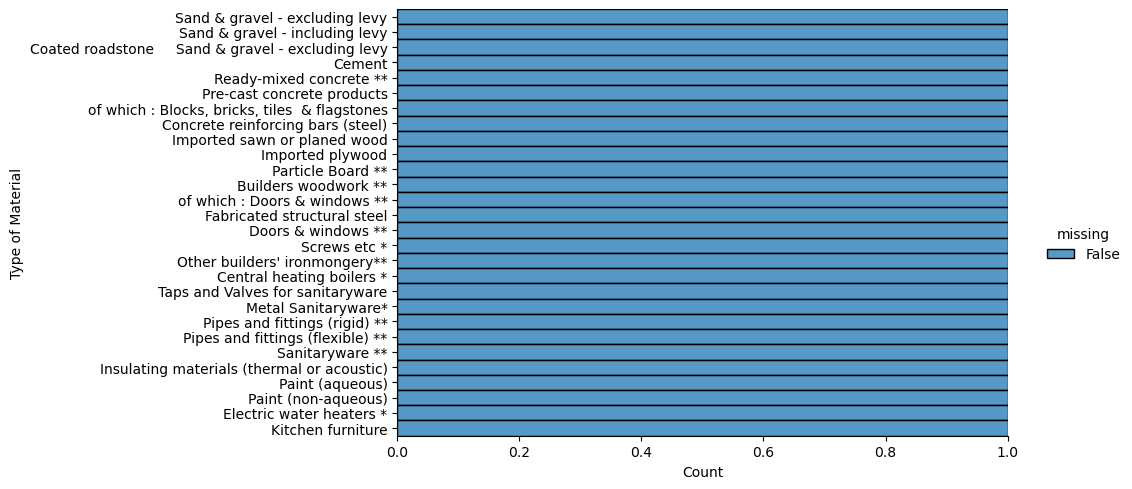

In [43]:
# seaborn visualisation
plt.figure(figsize=(18,6)) # setting figure size

sns.displot( 
    data=uk_df.isna().melt(value_name="missing"), # indicating if missing value is true
    y='Type of Material',
    hue="missing",
    multiple="fill",
    aspect=2.1
);


print(uk_df)

In [44]:
# Checking all missing data was filled
uk_df[uk_df.isna().any(axis=1)]

Empty DataFrame
Columns: [Sand & gravel - excluding levy, Sand & gravel - including levy, Coated roadstone     Sand & gravel - excluding levy, Cement, Ready-mixed concrete **, Pre-cast concrete products, of which : Blocks, bricks, tiles  & flagstones, Concrete reinforcing bars (steel), Imported sawn or planed wood, Imported plywood, Particle Board **, Builders woodwork **, of which : Doors & windows **, Fabricated structural steel, Doors & windows **, Screws etc *, Other builders' ironmongery**, Central heating boilers *, Taps and Valves for sanitaryware, Metal Sanitaryware*, Pipes and fittings (rigid) **, Pipes and fittings (flexible) **, Sanitaryware **, Insulating materials (thermal or acoustic), Paint (aqueous), Paint (non-aqueous), Electric water heaters *, Kitchen furniture]
Index: []

[0 rows x 28 columns]

In [45]:
duplicate_rows_df = uk_df[uk_df.duplicated()] # discovering duplicated rows
print("Number of duplicated rows in UK dataset: ", len(duplicate_rows_df))

Number of duplicated rows in UK dataset:  0


</br>

## Data Understanding 

In [46]:
ie_df

Type of Material  Materials  Stone, sand and gravel  Sand and gravel  Stone  \
Month                                                                         
2015 January           99.2                    95.7             98.0   95.3   
2015 February          99.0                    93.9             96.1   93.5   
2015 March             99.5                    98.1             97.5   98.2   
2015 April             99.8                    99.9            106.2   98.7   
2015 May              100.2                   100.5            103.1  100.0   
...                     ...                     ...              ...    ...   
2022 November         142.8                   116.4            131.1  113.5   
2022 December         142.9                   123.3            133.0  121.3   
2023 January          143.7                   120.9            131.0  118.8   
2023 February         144.0                   121.5            128.7  120.1   
2023 March            143.8                   120.9            120.9  120.9   

Type of Material  Cement  Ready mixed mortar and concrete  \
Month                                                       
2015 January       100.0                            101.6   
2015 February      100.0                            100.4   
2015 March         100.0                            100.1   
2015 April         100.0                             99.8   
2015 May           100.0                             99.6   
...                  ...                              ...   
2022 November      168.6                            146.0   
2022 December      168.6                            142.2   
2023 January       168.6                            144.6   
2023 February      168.6                            143.4   
2023 March         168.6                            143.7   

Type of Material  Concrete blocks and bricks  \
Month                                          
2015 January                           100.2   
2015 February                          100.6   
2015 March                              99.0   
2015 April                              99.3   
2015 May                                99.4   
...                                      ...   
2022 November                          128.7   
2022 December                          129.6   
2023 January                           129.2   
2023 February                          130.0   
2023 March                             131.5   

Type of Material  Other concrete products including precast  \
Month                                                         
2015 January                                           99.2   
2015 February                                          99.3   
2015 March                                             99.3   
2015 April                                             99.3   
2015 May                                               99.7   
...                                                     ...   
2022 November                                         128.1   
2022 December                                         128.9   
2023 January                                          129.9   
2023 February                                         129.9   
2023 March                                            129.9   

Type of Material  Other concrete products (excluding precast concrete)  \
Month                                                                    
2015 January                                                   99.4      
2015 February                                                  99.4      
2015 March                                                     99.4      
2015 April                                                     99.4      
2015 May                                                       99.4      
...                                                             ...      
2022 November                                                 125.8      
2022 December                                                 125.8

In [47]:
i = ie_df.columns
list(i)

['Materials',
 'Stone, sand and gravel',
 'Sand and gravel',
 'Stone',
 'Cement',
 'Ready mixed mortar and concrete',
 'Concrete blocks and bricks',
 'Other concrete products including precast',
 'Other concrete products (excluding precast concrete)',
 'Precast concrete',
 'Structural steel and reinforcing metal',
 'Structural steel',
 'Other structural steel',
 'Structural steel fabricated metal',
 'Reinforcing metal',
 'Other steel products',
 'Rough timber (including plain sawn)',
 'Rough timber (softwood)',
 'Rough timber (hardwood)',
 'Machined, treated engineered timber',
 'Other treated timber',
 'Wooden windows and doors',
 'Bituminous macadam, asphalt and bituminous emulsions',
 'Bituminous macadam and asphalt',
 'Bituminous emulsions',
 'Electrical fittings',
 'Lighting equipment',
 'Protection and communication equipment',
 'All other materials',
 'Plumbing materials including sanitary ware',
 'HVAC (heating and ventilation equipment)',
 'Insulating materials',
 'Pipes and f

In [48]:
u = uk_df.columns
list(u)

['Sand & gravel - excluding levy',
 'Sand & gravel - including levy',
 'Coated roadstone     Sand & gravel - excluding levy',
 'Cement',
 'Ready-mixed concrete **',
 'Pre-cast concrete products',
 'of which : Blocks, bricks, tiles  & flagstones',
 'Concrete reinforcing bars (steel)',
 'Imported sawn or planed wood',
 'Imported plywood',
 'Particle Board **',
 'Builders woodwork **',
 'of which : Doors & windows **',
 'Fabricated structural steel',
 'Doors & windows **',
 'Screws etc *',
 "Other builders' ironmongery**",
 'Central heating boilers *',
 'Taps and Valves for sanitaryware',
 'Metal Sanitaryware*',
 'Pipes and fittings (rigid) **',
 'Pipes and fittings (flexible) **',
 'Sanitaryware **',
 'Insulating materials (thermal or acoustic)',
 'Paint (aqueous)',
 'Paint (non-aqueous)',
 'Electric water heaters *',
 'Kitchen furniture']

#### Dictionary of similar data entries from Ireland and UK 

In [49]:
common_list_dict = {'Cement' : 'Cement', 
               'Sand and gravel' : 'Sand & gravel - including levy', 
               'Ready mixed mortar and concrete' : 'Ready-mixed concrete **',
               'Concrete blocks and bricks' : 'of which : Blocks, bricks, tiles  & flagstones',
               'Other concrete products including precast' : 'Pre-cast concrete products',
               'Structural steel fabricated metal' : 'Fabricated structural steel',
               'Reinforcing metal' : 'Concrete reinforcing bars (steel)',
               'Rough timber (including plain sawn)': 'Imported sawn or planed wood',
               'Machined, treated engineered timber' : 'Imported plywood',
               'Other treated timber' : 'Particle Board **',
               'Wooden windows and doors' : 'of which : Doors & windows **',
               'Plumbing materials including sanitary ware' : 'Taps and Valves for sanitaryware',
               'HVAC (heating and ventilation equipment)' : 'Central heating boilers *',
               'HVAC (heating and ventilation equipment)' : 'Electric water heaters *',
               'Insulating materials' : 'Insulating materials (thermal or acoustic)',
               'Copper pipes and fittings' : 'Pipes and fittings (rigid) **',
               'Pipes and fittings' : 'Pipes and fittings (flexible) **',
               'Paints, oils and varnishes' : 'Paint (aqueous)',
               'Paints, oils and varnishes' : 'Paint (non-aqueous)',
              }

In [162]:
headers = ['IE', 'UK']
col_nlewssts = []

cols = list(common_list_dict.keys())
vals = list(common_list_dict.values())
i = 0
for x in cols:
    try:
        col_nlewssts.append([cols[i], vals[i]])
        i += 1
    except:
        pass

newish_df = pd.DataFrame(col_nlewssts, columns=headers)
newish_df

IE  \
0                                       Cement   
1                              Sand and gravel   
2              Ready mixed mortar and concrete   
3                   Concrete blocks and bricks   
4    Other concrete products including precast   
5            Structural steel fabricated metal   
6                            Reinforcing metal   
7          Rough timber (including plain sawn)   
8          Machined, treated engineered timber   
9                         Other treated timber   
10                    Wooden windows and doors   
11  Plumbing materials including sanitary ware   
12    HVAC (heating and ventilation equipment)   
13                        Insulating materials   
14                   Copper pipes and fittings   
15                          Pipes and fittings   
16                  Paints, oils and varnishes   

                                                UK  
0                                           Cement  
1                   Sand & gravel - including levy  
2                          Ready-mixed concrete **  
3   of which : Blocks, bricks, tiles  & flagstones  
4                       Pre-cast concrete products  
5                      Fabricated structural steel  
6                Concrete reinforcing bars (steel)  
7                     Imported sawn or planed wood  
8                                 Imported plywood  
9                                Particle Board **  
10                   of which : Doors & windows **  
11                Taps and Valves for sanitaryware  
12                        Electric water heaters *  
13      Insulating materials (thermal or acoustic)  
14                   Pipes and fittings (rigid) **  
15                Pipes and fittings (flexible) **  
16                             Paint (non-aqueous)

#### IE data insights

In [50]:
cols = common_list_dict.keys()
print(list(cols))

['Cement', 'Sand and gravel', 'Ready mixed mortar and concrete', 'Concrete blocks and bricks', 'Other concrete products including precast', 'Structural steel fabricated metal', 'Reinforcing metal', 'Rough timber (including plain sawn)', 'Machined, treated engineered timber', 'Other treated timber', 'Wooden windows and doors', 'Plumbing materials including sanitary ware', 'HVAC (heating and ventilation equipment)', 'Insulating materials', 'Copper pipes and fittings', 'Pipes and fittings', 'Paints, oils and varnishes']


In [51]:
ncols = list(cols)
new_ie_df = ie_df[ncols]
new_ie_df

Type of Material  Cement  Sand and gravel  Ready mixed mortar and concrete  \
Month                                                                        
2015 January       100.0             98.0                            101.6   
2015 February      100.0             96.1                            100.4   
2015 March         100.0             97.5                            100.1   
2015 April         100.0            106.2                             99.8   
2015 May           100.0            103.1                             99.6   
...                  ...              ...                              ...   
2022 November      168.6            131.1                            146.0   
2022 December      168.6            133.0                            142.2   
2023 January       168.6            131.0                            144.6   
2023 February      168.6            128.7                            143.4   
2023 March         168.6            120.9                            143.7   

Type of Material  Concrete blocks and bricks  \
Month                                          
2015 January                           100.2   
2015 February                          100.6   
2015 March                              99.0   
2015 April                              99.3   
2015 May                                99.4   
...                                      ...   
2022 November                          128.7   
2022 December                          129.6   
2023 January                           129.2   
2023 February                          130.0   
2023 March                             131.5   

Type of Material  Other concrete products including precast  \
Month                                                         
2015 January                                           99.2   
2015 February                                          99.3   
2015 March                                             99.3   
2015 April                                             99.3   
2015 May                                               99.7   
...                                                     ...   
2022 November                                         128.1   
2022 December                                         128.9   
2023 January                                          129.9   
2023 February                                         129.9   
2023 March                                            129.9   

Type of Material  Structural steel fabricated metal  Reinforcing metal  \
Month                                                                    
2015 January                                   97.3              100.7   
2015 February                                  97.3              100.9   
2015 March                                     97.9              100.8   
2015 April                                     99.3              100.6   
2015 May                                       99.3              100.4   
...                                             ...                ...   
2022 November                                 207.7              190.5   
2022 December                                 207.7              188.3   
2023 January                                  229.9              174.8   
2023 February                                 229.9              173.2   
2023 March                                    229.9              170.6   

Type of Material  Rough timber (including plain sawn)  \
Month                                                   
2015 January                                     99.5   
2015 February                                    99.9   
2015 March                                      100.0   
2015 April                                      100.0   
2015 May                                        100.0   
...                                               ...   
2022 November                                   155.7   
2022 December                                   154.5   
2023 Ja

In [52]:
ie_avg_monthly_pct_change = new_ie_df.pct_change(periods=1) * 100
ie_avg_monthly_pct_change = ie_avg_monthly_pct_change.fillna(0) # first row does now have any price change values, so assign a 0 at start
ie_avg_monthly_pct_change

Type of Material   Cement  Sand and gravel  Ready mixed mortar and concrete  \
Month                                                                         
2015 January      0.00000         0.000000                         0.000000   
2015 February     0.00000        -1.938776                        -1.181102   
2015 March        0.00000         1.456816                        -0.298805   
2015 April        0.00000         8.923077                        -0.299700   
2015 May          0.00000        -2.919021                        -0.200401   
...                   ...              ...                              ...   
2022 November     7.93854         0.306044                         3.693182   
2022 December     0.00000         1.449275                        -2.602740   
2023 January      0.00000        -1.503759                         1.687764   
2023 February     0.00000        -1.755725                        -0.829876   
2023 March        0.00000        -6.060606                         0.209205   

Type of Material  Concrete blocks and bricks  \
Month                                          
2015 January                        0.000000   
2015 February                       0.399202   
2015 March                         -1.590457   
2015 April                          0.303030   
2015 May                            0.100705   
...                                      ...   
2022 November                       1.179245   
2022 December                       0.699301   
2023 January                       -0.308642   
2023 February                       0.619195   
2023 March                          1.153846   

Type of Material  Other concrete products including precast  \
Month                                                         
2015 January                                       0.000000   
2015 February                                      0.100806   
2015 March                                         0.000000   
2015 April                                         0.000000   
2015 May                                           0.402820   
...                                                     ...   
2022 November                                      0.000000   
2022 December                                      0.624512   
2023 January                                       0.775795   
2023 February                                      0.000000   
2023 March                                         0.000000   

Type of Material  Structural steel fabricated metal  Reinforcing metal  \
Month                                                                    
2015 January                               0.000000           0.000000   
2015 February                              0.000000           0.198610   
2015 March                                 0.616650          -0.099108   
2015 April                                 1.430031          -0.198413   
2015 May                                   0.000000          -0.198807   
...                                             ...                ...   
2022 November                              0.483793          -1.448526   
2022 December                              0.000000          -1.154856   
2023 January                              10.688493          -7.169411   
2023 February                              0.000000          -0.915332   
2023 March                                 0.000000          -1.501155   

Type of Material  Rough timber (including plain sawn)  \
Month                                                   
2015 January                                 0.000000   
2015 February                                0.402010   
2015 March                                   0.100100   
2015 April                                   0.000000   
2015 May                                     0.000000   
...                                               ...   
2022 November                               -1.952141   
2022 December                               -0.7707

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_56195/1158979209.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])


[Text(5, 0, '0.54%'),
 Text(5, 0, '0.37%'),
 Text(5, 0, '0.36%'),
 Text(5, 0, '0.28%'),
 Text(5, 0, '0.28%'),
 Text(5, 0, '0.94%'),
 Text(5, 0, '0.57%'),
 Text(5, 0, '0.47%'),
 Text(5, 0, '0.62%'),
 Text(5, 0, '1.02%'),
 Text(5, 0, '0.36%'),
 Text(5, 0, '0.42%'),
 Text(5, 0, '0.17%'),
 Text(5, 0, '0.27%'),
 Text(5, 0, '0.38%'),
 Text(5, 0, '0.42%'),
 Text(5, 0, '0.45%')]

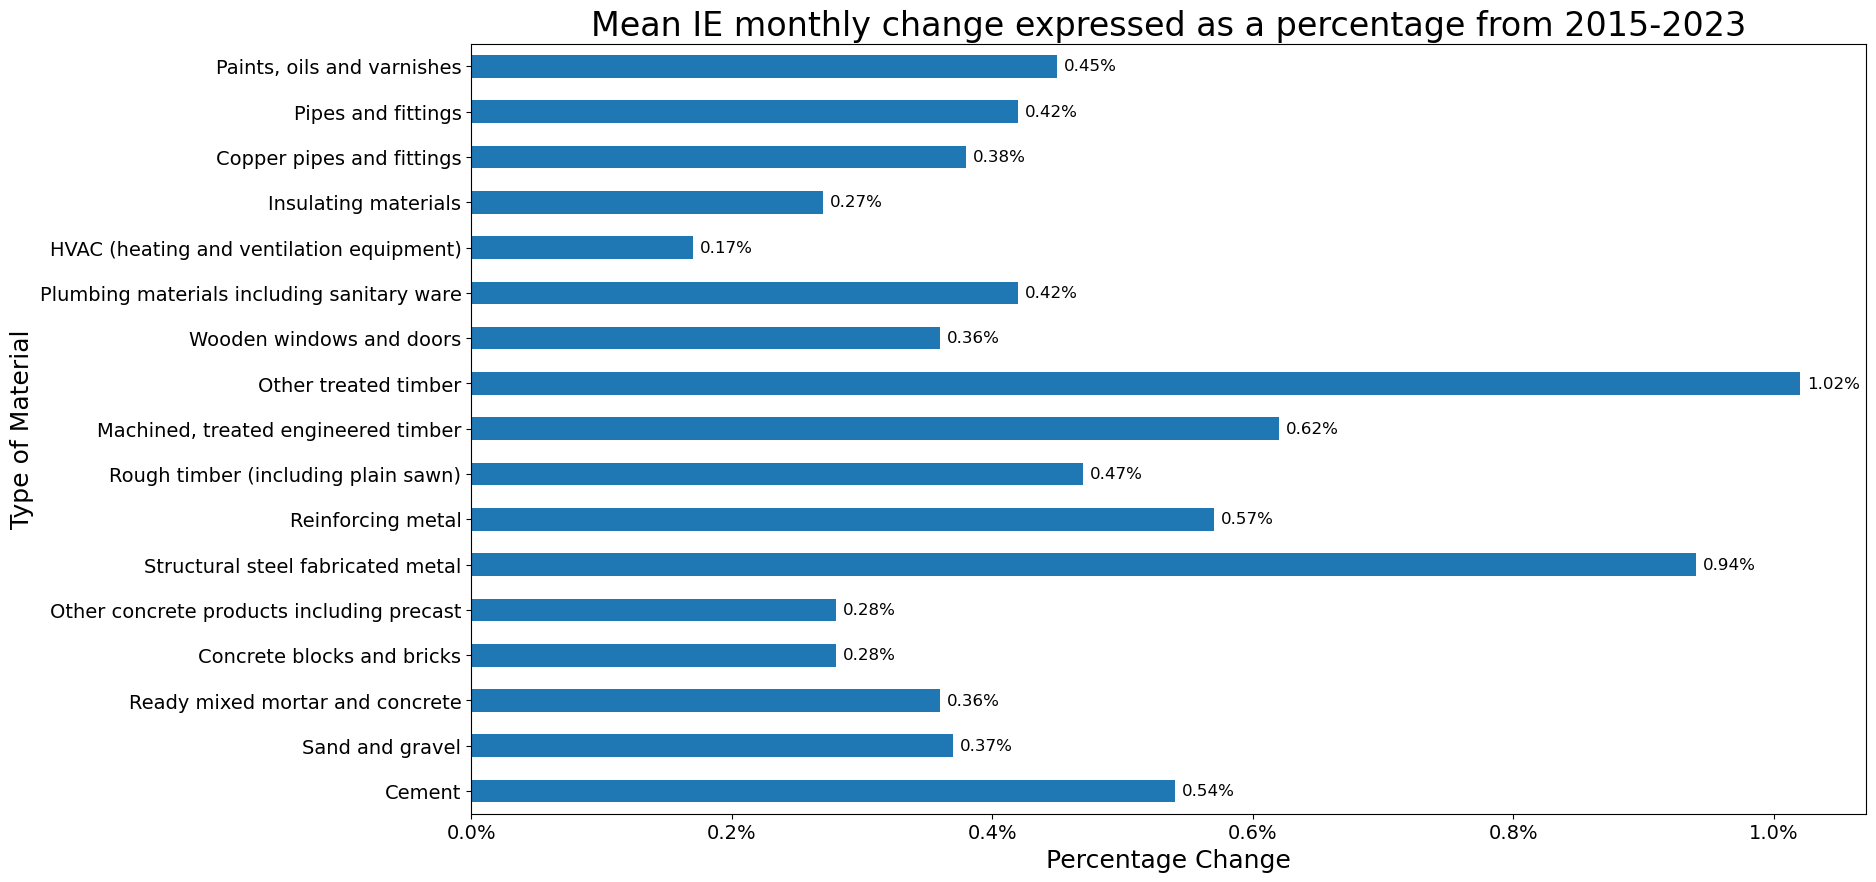

In [53]:
ie_avg_monthly_pct_change = round(ie_avg_monthly_pct_change.mean(), 2)

plt.figure(figsize=(18,10))
ax = ie_avg_monthly_pct_change.plot.barh()

plt.title("Mean IE monthly change expressed as a percentage from 2015-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])

plt.bar_label(ax.containers[0], padding = 5 , size=12 , fmt='%.2f%%')

In [167]:
ie_avg_monthly_pct_change.sort_values(ascending = False).to_frame()

0
Type of Material                                
Other treated timber                        1.02
Structural steel fabricated metal           0.94
Machined, treated engineered timber         0.62
Reinforcing metal                           0.57
Cement                                      0.54
Rough timber (including plain sawn)         0.47
Paints, oils and varnishes                  0.45
Plumbing materials including sanitary ware  0.42
Pipes and fittings                          0.42
Copper pipes and fittings                   0.38
Sand and gravel                             0.37
Ready mixed mortar and concrete             0.36
Wooden windows and doors                    0.36
Other concrete products including precast   0.28
Concrete blocks and bricks                  0.28
Insulating materials                        0.27
HVAC (heating and ventilation equipment)    0.17

In [168]:
ie_avg_monthly_pct_change.sort_values(ascending = False).mean()

0.4658823529411766

In [169]:
ie_avg_monthly_pct_change.sort_values(ascending = False).std()

0.22505718227623314

In [510]:
ie_stat_test = avg_monthly_pct_change.sort_values(ascending = False)
a = ie_stat_test[:3].to_frame().index.to_list()
b = ie_stat_test[-3:].to_frame().index.to_list()

ie_stat_test = a+b
ie_stat_test

['Other treated timber',
 'Structural steel fabricated metal',
 'Machined, treated engineered timber',
 'Concrete blocks and bricks',
 'Insulating materials',
 'HVAC (heating and ventilation equipment)']

In [470]:
avg_monthly_pct_change.sort_values(ascending = False)

Type of Material
Concrete reinforcing bars (steel)                 1.05
Fabricated structural steel                       1.03
Insulating materials (thermal or acoustic)        0.68
Imported sawn or planed wood                      0.67
Pre-cast concrete products                        0.57
Sand & gravel - including levy                    0.47
Imported plywood                                  0.39
of which : Blocks, bricks, tiles  & flagstones    0.39
Taps and Valves for sanitaryware                  0.37
Pipes and fittings (flexible) **                  0.36
Pipes and fittings (rigid) **                     0.29
Cement                                            0.27
of which : Doors & windows **                     0.24
Particle Board **                                 0.24
Ready-mixed concrete **                           0.23
Paint (non-aqueous)                               0.16
Electric water heaters *                         -0.08
dtype: float64

In [ ]:
common_list_dict = {'Cement' : 'Cement', 
               'Sand and gravel' : 'Sand & gravel - including levy', 
               'Ready mixed mortar and concrete' : 'Ready-mixed concrete **',
               'Concrete blocks and bricks' : 'of which : Blocks, bricks, tiles  & flagstones',
               'Other concrete products including precast' : 'Pre-cast concrete products',
               'Structural steel fabricated metal' : 'Fabricated structural steel',
               'Reinforcing metal' : 'Concrete reinforcing bars (steel)',
               'Rough timber (including plain sawn)': 'Imported sawn or planed wood',
               'Machined, treated engineered timber' : 'Imported plywood',
               'Other treated timber' : 'Particle Board **',
               'Wooden windows and doors' : 'of which : Doors & windows **',
               'Plumbing materials including sanitary ware' : 'Taps and Valves for sanitaryware',
               'HVAC (heating and ventilation equipment)' : 'Central heating boilers *',
               'HVAC (heating and ventilation equipment)' : 'Electric water heaters *',
               'Insulating materials' : 'Insulating materials (thermal or acoustic)',
               'Copper pipes and fittings' : 'Pipes and fittings (rigid) **',
               'Pipes and fittings' : 'Pipes and fittings (flexible) **',
               'Paints, oils and varnishes' : 'Paint (aqueous)',
               'Paints, oils and varnishes' : 'Paint (non-aqueous)',
              }

In [483]:
uk_stat_test = avg_monthly_pct_change.sort_values(ascending = False)
uk_stat_test[:3] , uk_stat_test[-3:]

(Type of Material
 Concrete reinforcing bars (steel)             1.05
 Fabricated structural steel                   1.03
 Insulating materials (thermal or acoustic)    0.68
 dtype: float64,
 Type of Material
 Ready-mixed concrete **     0.23
 Paint (non-aqueous)         0.16
 Electric water heaters *   -0.08
 dtype: float64)

highest costs are for structural dependant materials. Anything required to build the skeleton of the building.

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_56195/3041026970.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])


[Text(5, 0, '2.04%'),
 Text(5, 0, '3.24%'),
 Text(5, 0, '3.36%'),
 Text(5, 0, '3.36%'),
 Text(5, 0, '4.32%'),
 Text(5, 0, '4.32%'),
 Text(5, 0, '4.44%'),
 Text(5, 0, '4.56%'),
 Text(5, 0, '5.04%'),
 Text(5, 0, '5.04%'),
 Text(5, 0, '5.40%'),
 Text(5, 0, '5.64%'),
 Text(5, 0, '6.48%'),
 Text(5, 0, '6.84%'),
 Text(5, 0, '7.44%'),
 Text(5, 0, '11.28%'),
 Text(5, 0, '12.24%')]

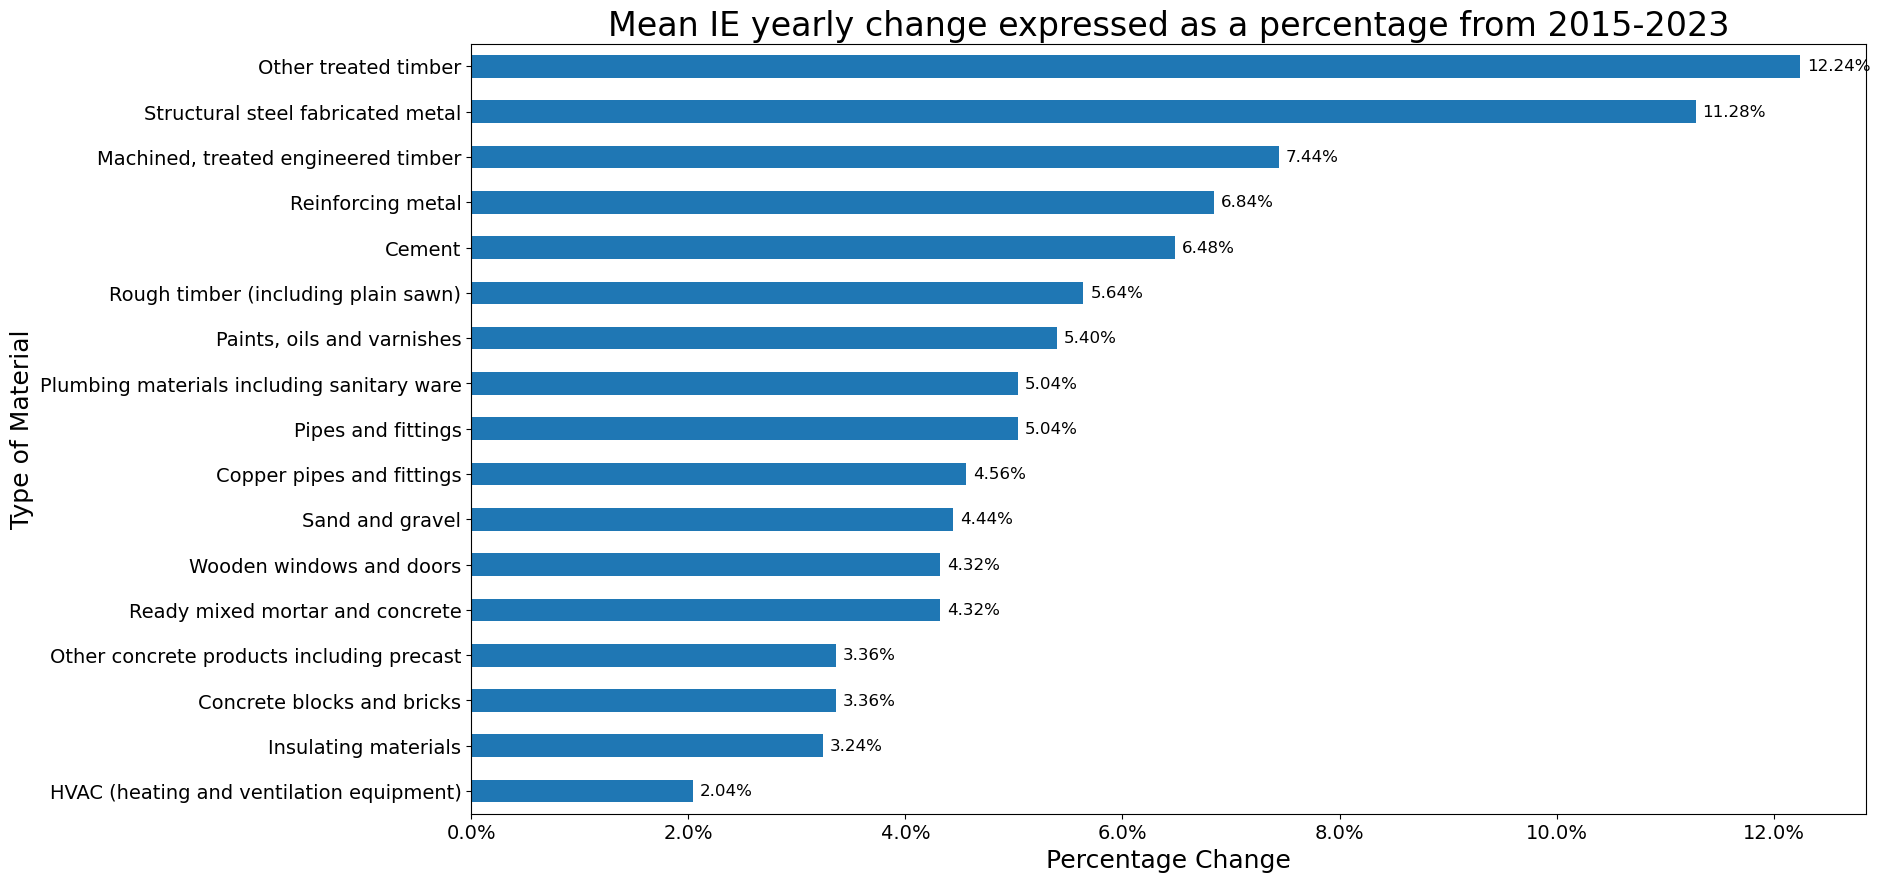

In [179]:
ie_avg_yearly_pct_change = (ie_avg_monthly_pct_change * 12).sort_values(ascending=True)

plt.figure(figsize=(18,10))
ax = ie_avg_yearly_pct_change.plot.barh()

plt.title("Mean IE yearly change expressed as a percentage from 2015-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])

plt.bar_label(ax.containers[0], padding = 5 , size=12 , fmt='%.2f%%')

[Text(5, 0, '104.7'),
 Text(5, 0, '105.2'),
 Text(5, 0, '105.9'),
 Text(5, 0, '106'),
 Text(5, 0, '107.2'),
 Text(5, 0, '107.2'),
 Text(5, 0, '108.6'),
 Text(5, 0, '108.8'),
 Text(5, 0, '109.4'),
 Text(5, 0, '114.5'),
 Text(5, 0, '115.5'),
 Text(5, 0, '115.6'),
 Text(5, 0, '117'),
 Text(5, 0, '119.3'),
 Text(5, 0, '120.3'),
 Text(5, 0, '121.4'),
 Text(5, 0, '127.7')]

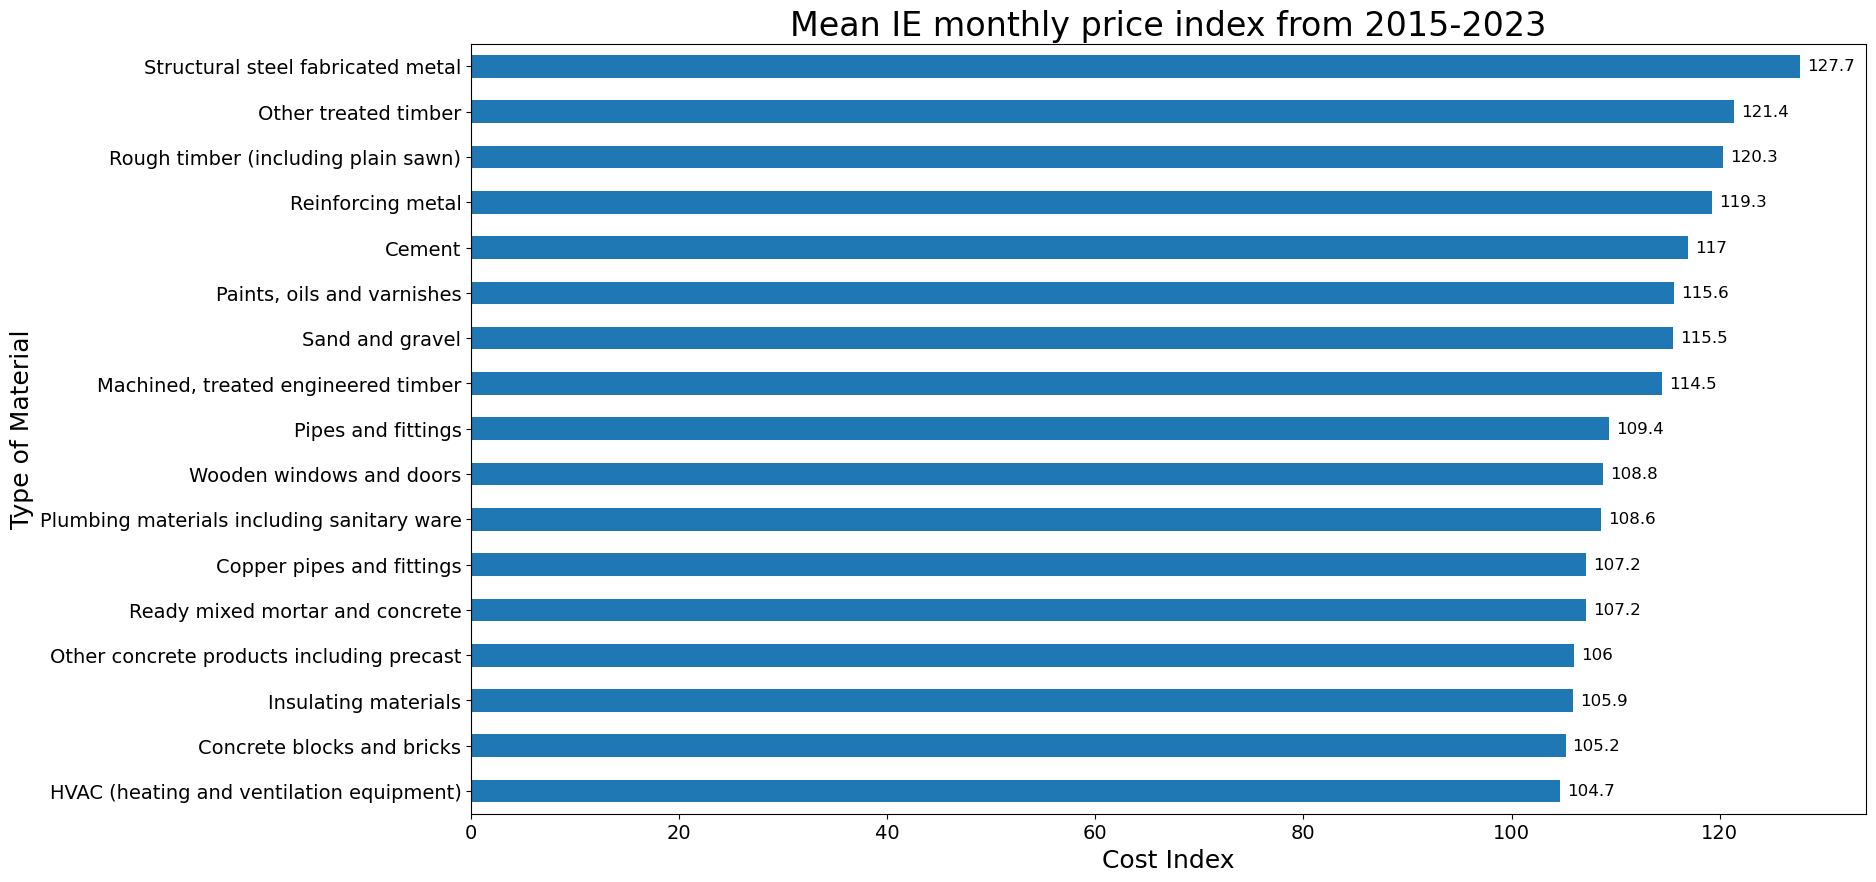

In [208]:
pindex = (round(new_ie_df.mean(), 1))
pindex = pindex.sort_values(ascending=True)

plt.figure(figsize=(18,10))
ax = pindex.plot.barh()

plt.title("Mean IE monthly price index from 2015-2023", fontsize="24")
plt.xlabel("Cost Index", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.bar_label(ax.containers[0], padding = 5 , size=12)

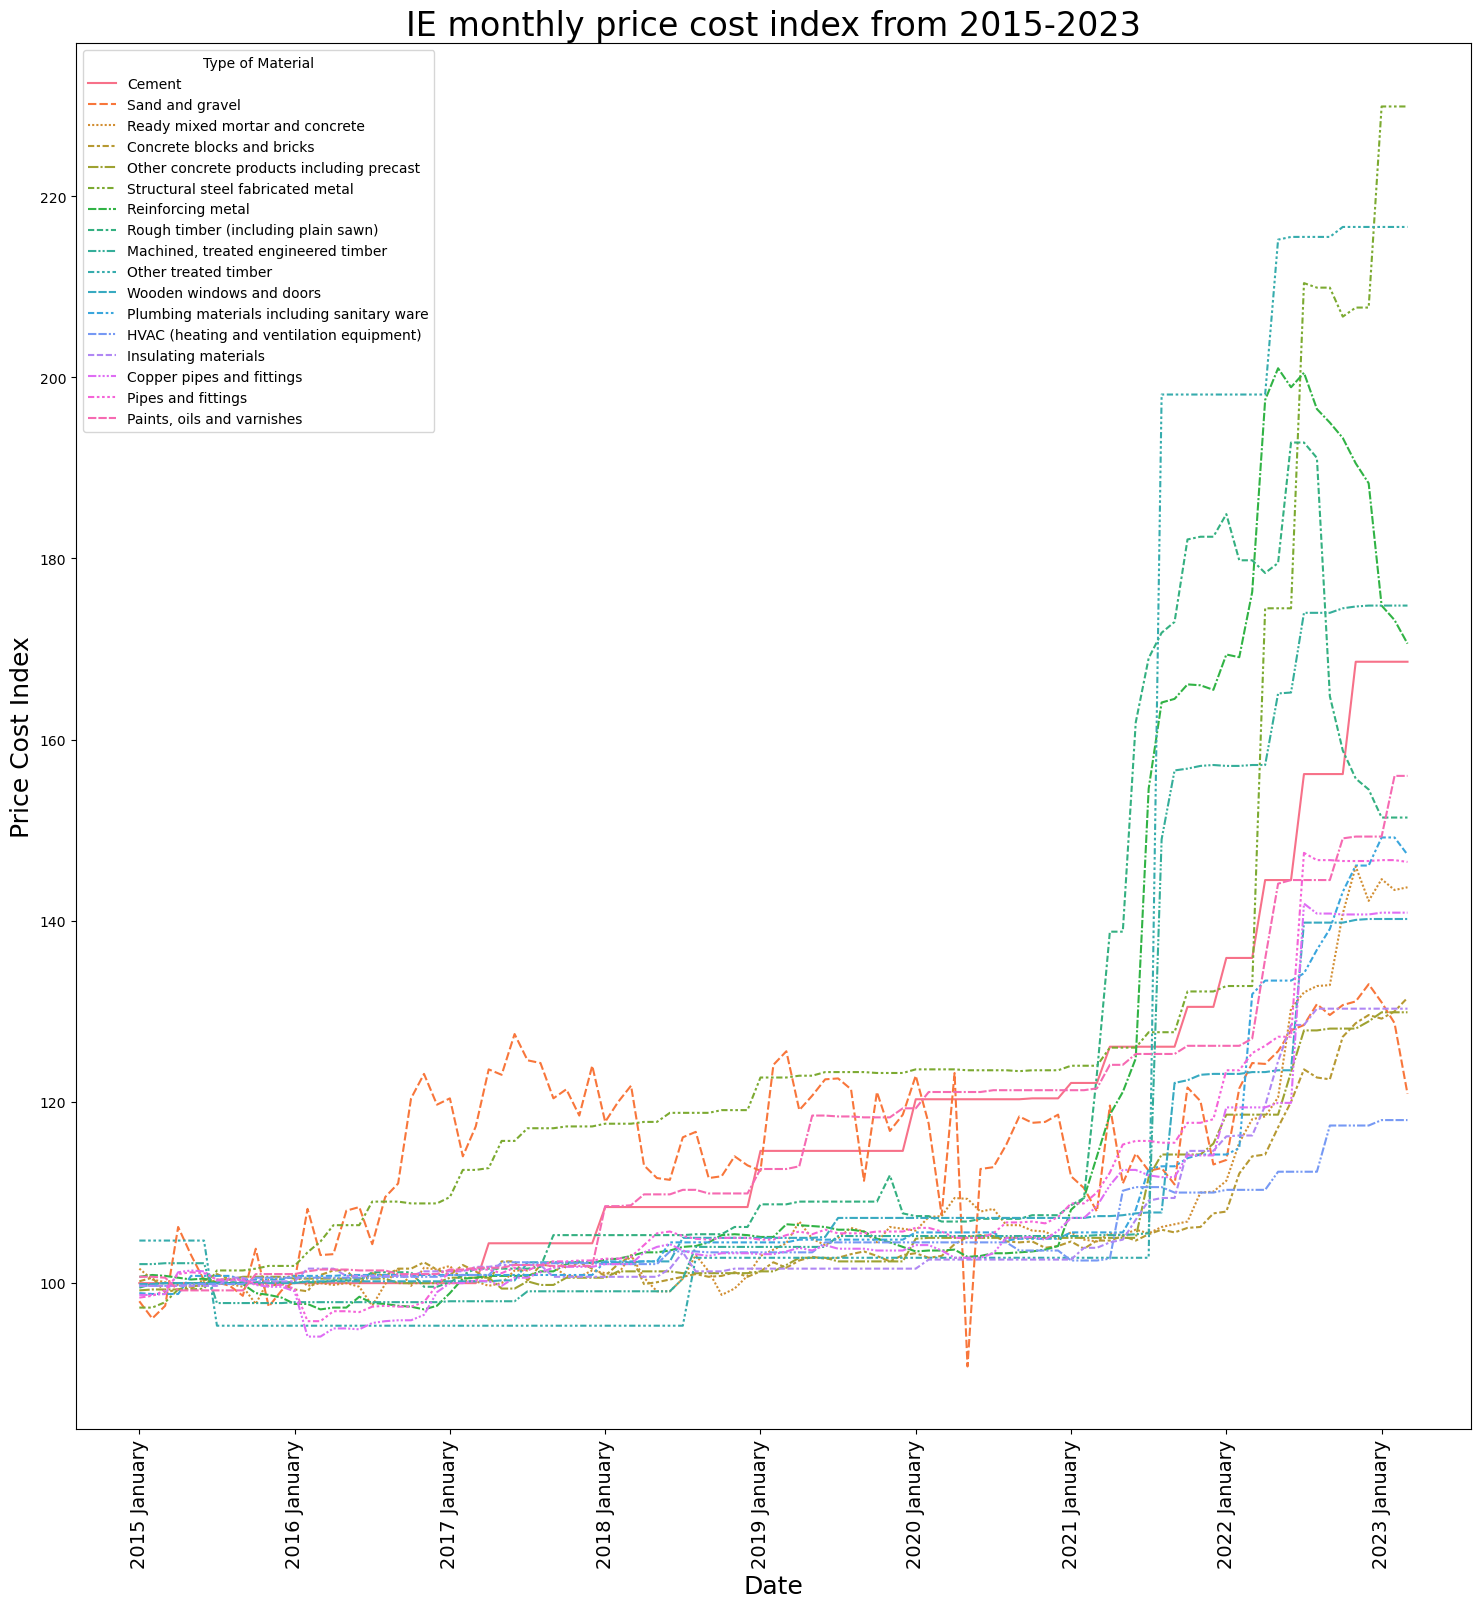

In [211]:
plt.figure(figsize=(18,18))

sns_plot = sns.lineplot(data = new_ie_df , ci = None)

plt.title("IE monthly price cost index from 2015-2023", fontsize="24")
plt.xlabel("Date", fontsize="18")
plt.ylabel("Price Cost Index", fontsize="18")
plt.xticks(plt.xticks()[0], rotation=90, size = 14)
sns_plot.xaxis.get_major_locator()  
sns_plot.xaxis.set_major_locator(ticker.MultipleLocator(12))

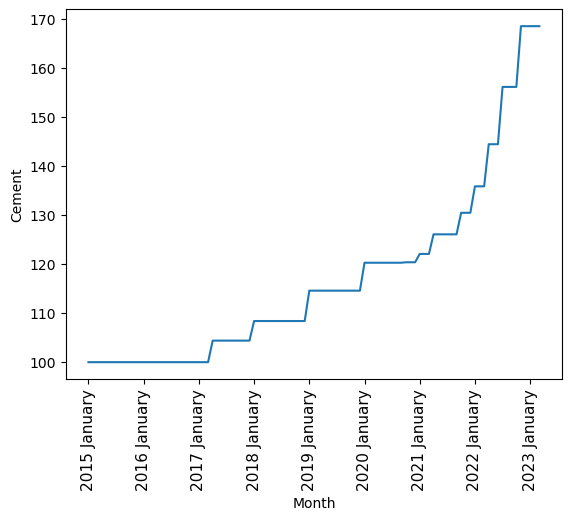

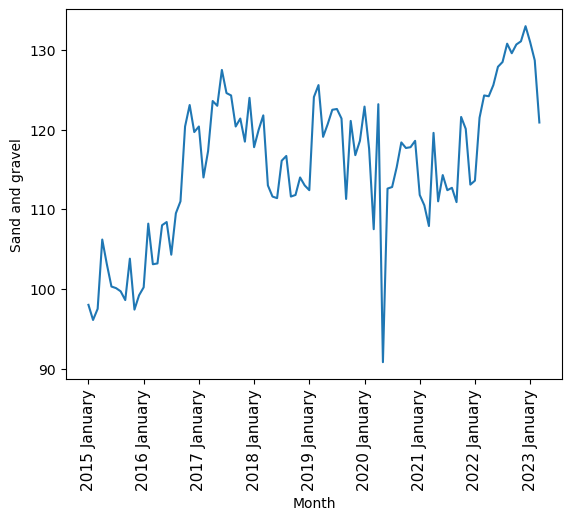

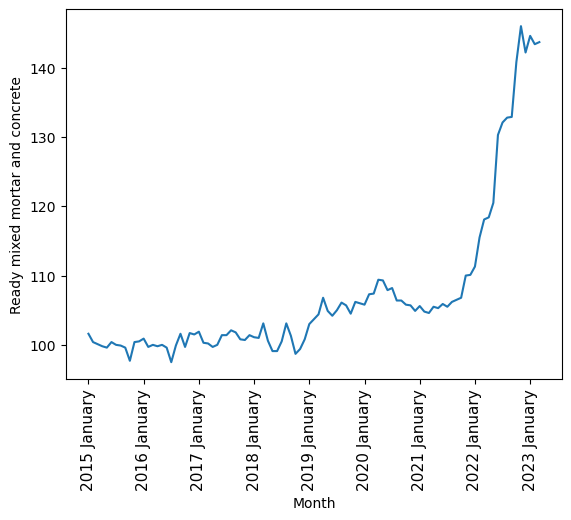

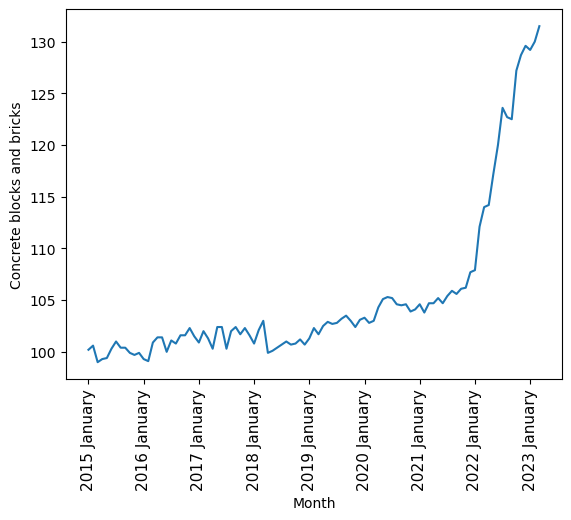

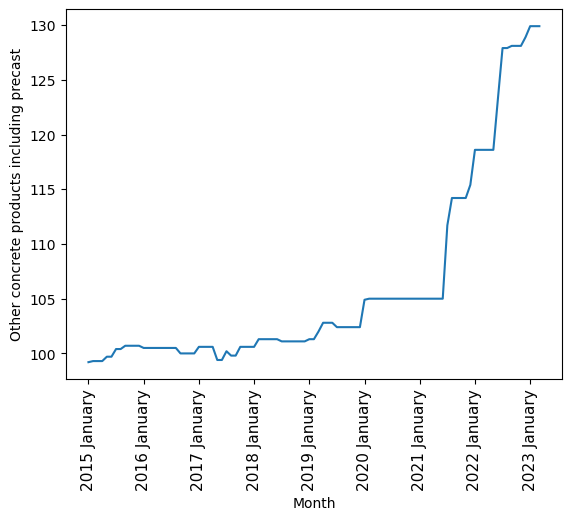

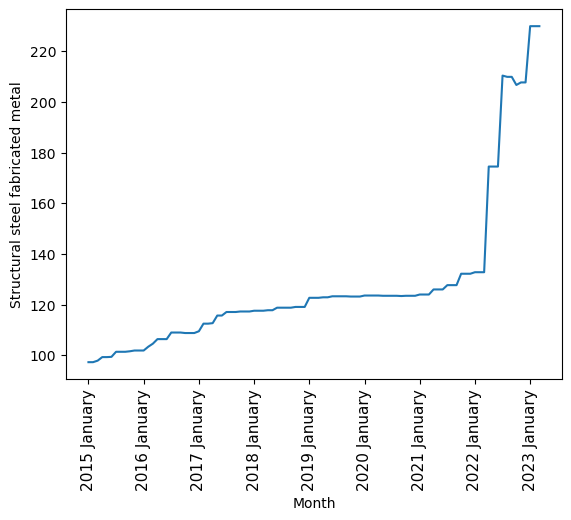

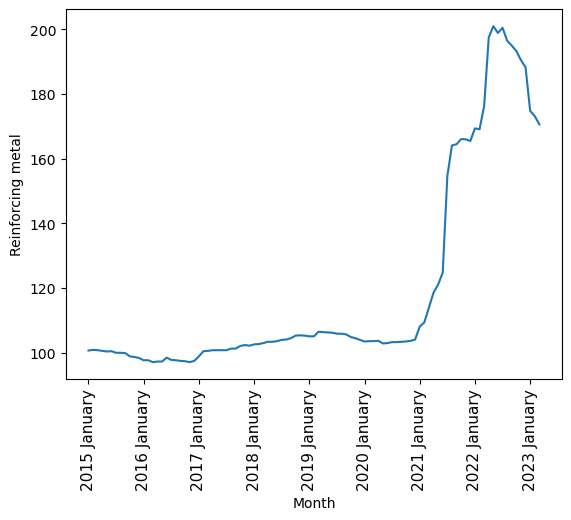

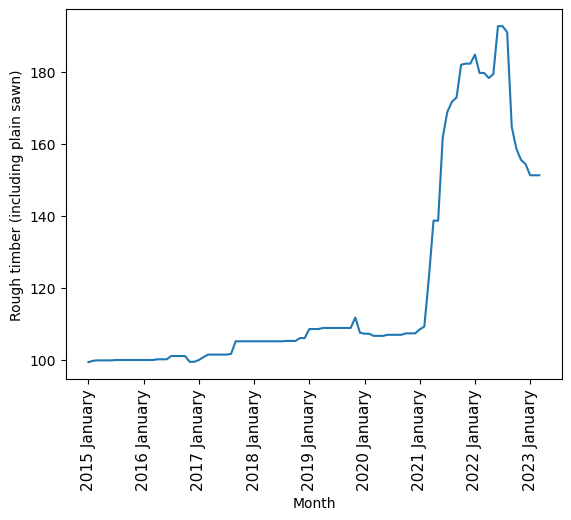

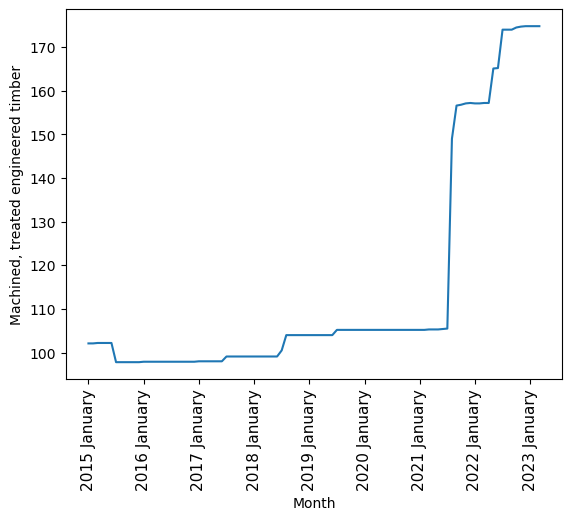

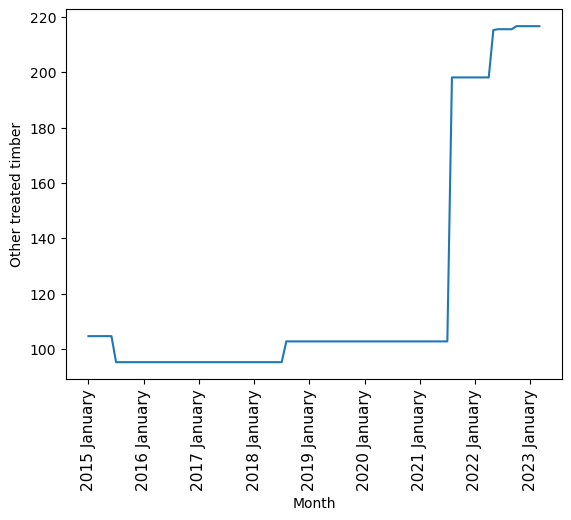

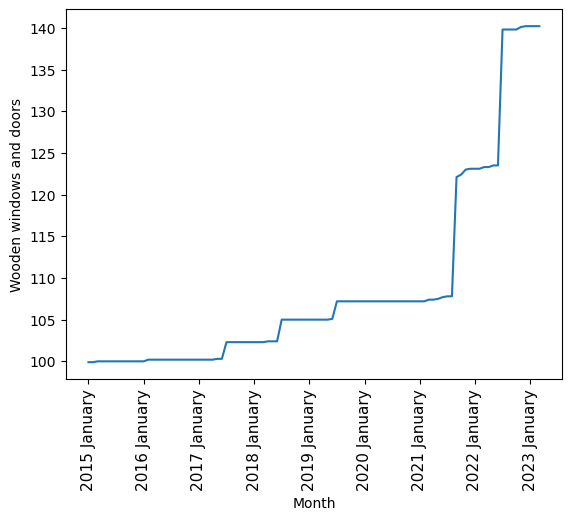

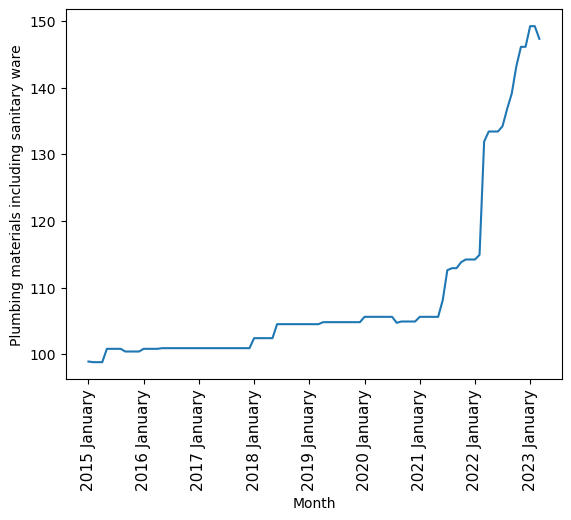

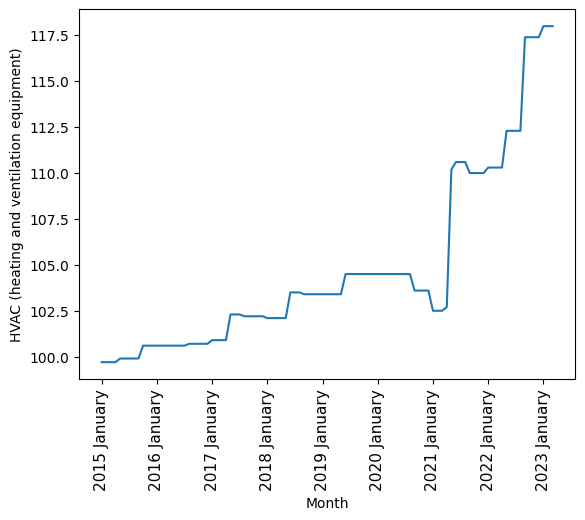

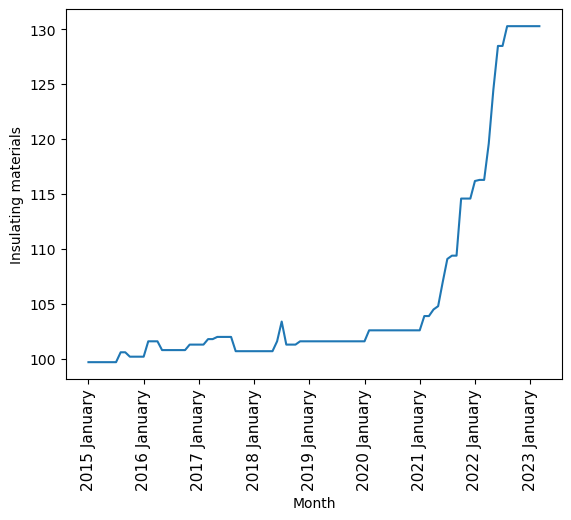

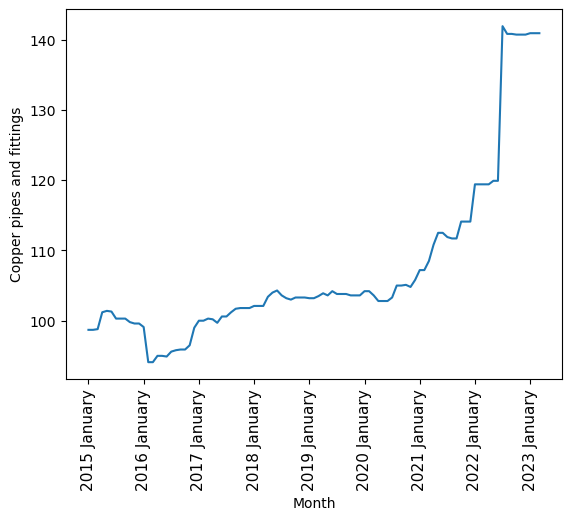

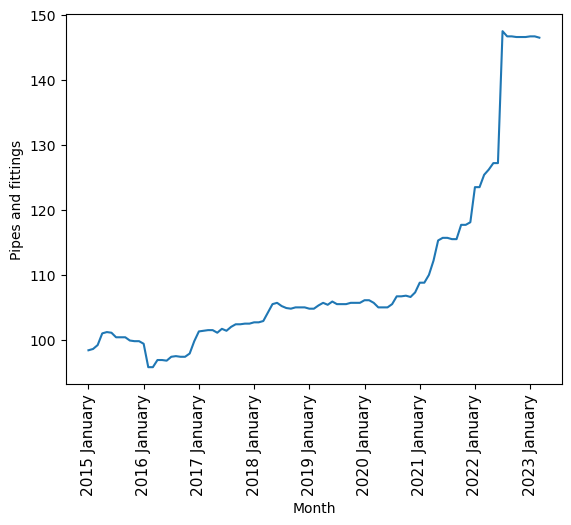

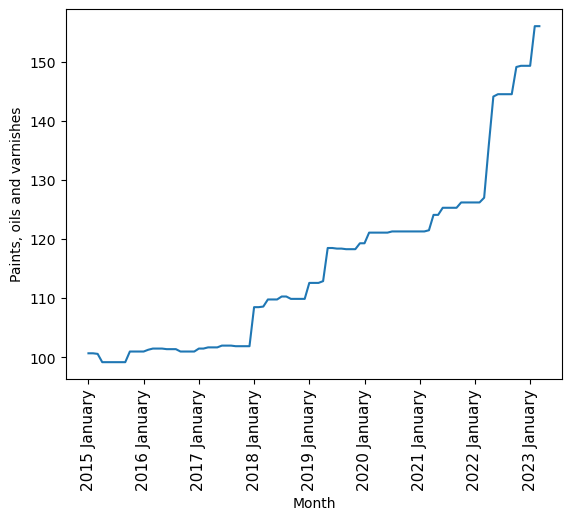

In [57]:
for i in new_ie_df.columns:
    plt.figure()
    plt.tight_layout()
    line_plot = sns.lineplot(data = new_ie_df,  x = new_ie_df.index, y = i)
    plt.xticks(plt.xticks()[0], rotation=90, size = 11)
    line_plot.xaxis.get_major_locator()  
    line_plot.xaxis.set_major_locator(ticker.MultipleLocator(12))

#### UK data Insights

In [58]:
uk_cols = common_list_dict.values()
print(list(uk_cols))

['Cement', 'Sand & gravel - including levy', 'Ready-mixed concrete **', 'of which : Blocks, bricks, tiles  & flagstones', 'Pre-cast concrete products', 'Fabricated structural steel', 'Concrete reinforcing bars (steel)', 'Imported sawn or planed wood', 'Imported plywood', 'Particle Board **', 'of which : Doors & windows **', 'Taps and Valves for sanitaryware', 'Electric water heaters *', 'Insulating materials (thermal or acoustic)', 'Pipes and fittings (rigid) **', 'Pipes and fittings (flexible) **', 'Paint (non-aqueous)']


In [59]:
uk_cols = list(uk_cols)
new_uk_df = uk_df[uk_cols]
new_uk_df

Type of Material  Cement  Sand & gravel - including levy  \
Month                                                      
2017 February      119.9                           121.7   
2017 March         120.5                           121.7   
2017 April         119.6                           121.6   
2017 May           117.6                           121.7   
2017 June          117.6                           121.3   
...                  ...                             ...   
2022 October       132.6                           161.5   
2022 November      134.4                           164.0   
2022 December      138.3                           164.0   
2023 January       143.3                           164.0   
2023 February      143.6                           164.0   

Type of Material  Ready-mixed concrete **  \
Month                                       
2017 February                       118.7   
2017 March                          117.7   
2017 April                          117.9   
2017 May                            118.3   
2017 June                           119.4   
...                                   ...   
2022 October                        132.1   
2022 November                       134.3   
2022 December                       136.0   
2023 January                        137.0   
2023 February                       137.0   

Type of Material  of which : Blocks, bricks, tiles  & flagstones  \
Month                                                              
2017 February                                              123.7   
2017 March                                                 124.6   
2017 April                                                 124.7   
2017 May                                                   125.9   
2017 June                                                  126.4   
...                                                          ...   
2022 October                                               151.4   
2022 November                                              150.8   
2022 December                                              151.7   
2023 January                                               156.1   
2023 February                                              161.9   

Type of Material  Pre-cast concrete products  Fabricated structural steel  \
Month                                                                       
2017 February                          119.4                         95.2   
2017 March                             120.0                         95.6   
2017 April                             120.0                         96.8   
2017 May                               120.9                         96.6   
2017 June                              121.2                         97.7   
...                                      ...                          ...   
2022 October                           168.1                        207.2   
2022 November                          169.6                        199.3   
2022 December                          170.2                        195.8   
2023 January                           172.8                        186.9   
2023 February                          178.2                        189.0   

Type of Material  Concrete reinforcing bars (steel)  \
Month                                                 
2017 February                                  92.7   
2017 March                                     92.9   
2017 April                                     93.0   
2017 May                                       91.3   
2017 June                                      90.1   
...                                             ...   
2022 October                                  201.6   
2022 November                                 199.9   
2022 December                                 199.6   
2023 January                                  185.2   
2023 February                                 185.8   

Type of Material  Imported saw

In [60]:
uk_avg_monthly_pct_change = new_uk_df.pct_change(periods=1) * 100
uk_avg_monthly_pct_change = uk_avg_monthly_pct_change.fillna(0)
uk_avg_monthly_pct_change

Type of Material    Cement  Sand & gravel - including levy  \
Month                                                        
2017 February     0.000000                        0.000000   
2017 March        0.500417                        0.000000   
2017 April       -0.746888                       -0.082169   
2017 May         -1.672241                        0.082237   
2017 June         0.000000                       -0.328677   
...                    ...                             ...   
2022 October      0.226757                        0.000000   
2022 November     1.357466                        1.547988   
2022 December     2.901786                        0.000000   
2023 January      3.615329                        0.000000   
2023 February     0.209351                        0.000000   

Type of Material  Ready-mixed concrete **  \
Month                                       
2017 February                    0.000000   
2017 March                      -0.842460   
2017 April                       0.169924   
2017 May                         0.339271   
2017 June                        0.929839   
...                                   ...   
2022 October                     0.609292   
2022 November                    1.665405   
2022 December                    1.265823   
2023 January                     0.735294   
2023 February                    0.000000   

Type of Material  of which : Blocks, bricks, tiles  & flagstones  \
Month                                                              
2017 February                                           0.000000   
2017 March                                              0.727567   
2017 April                                              0.080257   
2017 May                                                0.962310   
2017 June                                               0.397141   
...                                                          ...   
2022 October                                            1.270903   
2022 November                                          -0.396301   
2022 December                                           0.596817   
2023 January                                            2.900461   
2023 February                                           3.715567   

Type of Material  Pre-cast concrete products  Fabricated structural steel  \
Month                                                                       
2017 February                       0.000000                     0.000000   
2017 March                          0.502513                     0.420168   
2017 April                          0.000000                     1.255230   
2017 May                            0.750000                    -0.206612   
2017 June                           0.248139                     1.138716   
...                                      ...                          ...   
2022 October                        1.693890                    -6.498195   
2022 November                       0.892326                    -3.812741   
2022 December                       0.353774                    -1.756147   
2023 January                        1.527615                    -4.545455   
2023 February                       3.125000                     1.123596   

Type of Material  Concrete reinforcing bars (steel)  \
Month                                                 
2017 February                              0.000000   
2017 March                                 0.215750   
2017 April                                 0.107643   
2017 May                                  -1.827957   
2017 June                                 -1.314348   
...                                             ...   
2022 October                              -6.753006   
2022 November                             -0.843254   
2022 December                             -0.150075   
2023 January                              -7.214429   
2023 February                              0.323974   

Type

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_56195/2035275699.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])


[Text(5, 0, '0.27%'),
 Text(5, 0, '0.47%'),
 Text(5, 0, '0.23%'),
 Text(5, 0, '0.39%'),
 Text(5, 0, '0.57%'),
 Text(5, 0, '1.03%'),
 Text(5, 0, '1.05%'),
 Text(5, 0, '0.67%'),
 Text(5, 0, '0.39%'),
 Text(5, 0, '0.24%'),
 Text(5, 0, '0.24%'),
 Text(5, 0, '0.35%'),
 Text(-5, 0, '-0.08%'),
 Text(5, 0, '0.68%'),
 Text(5, 0, '0.29%'),
 Text(5, 0, '0.36%'),
 Text(5, 0, '0.16%')]

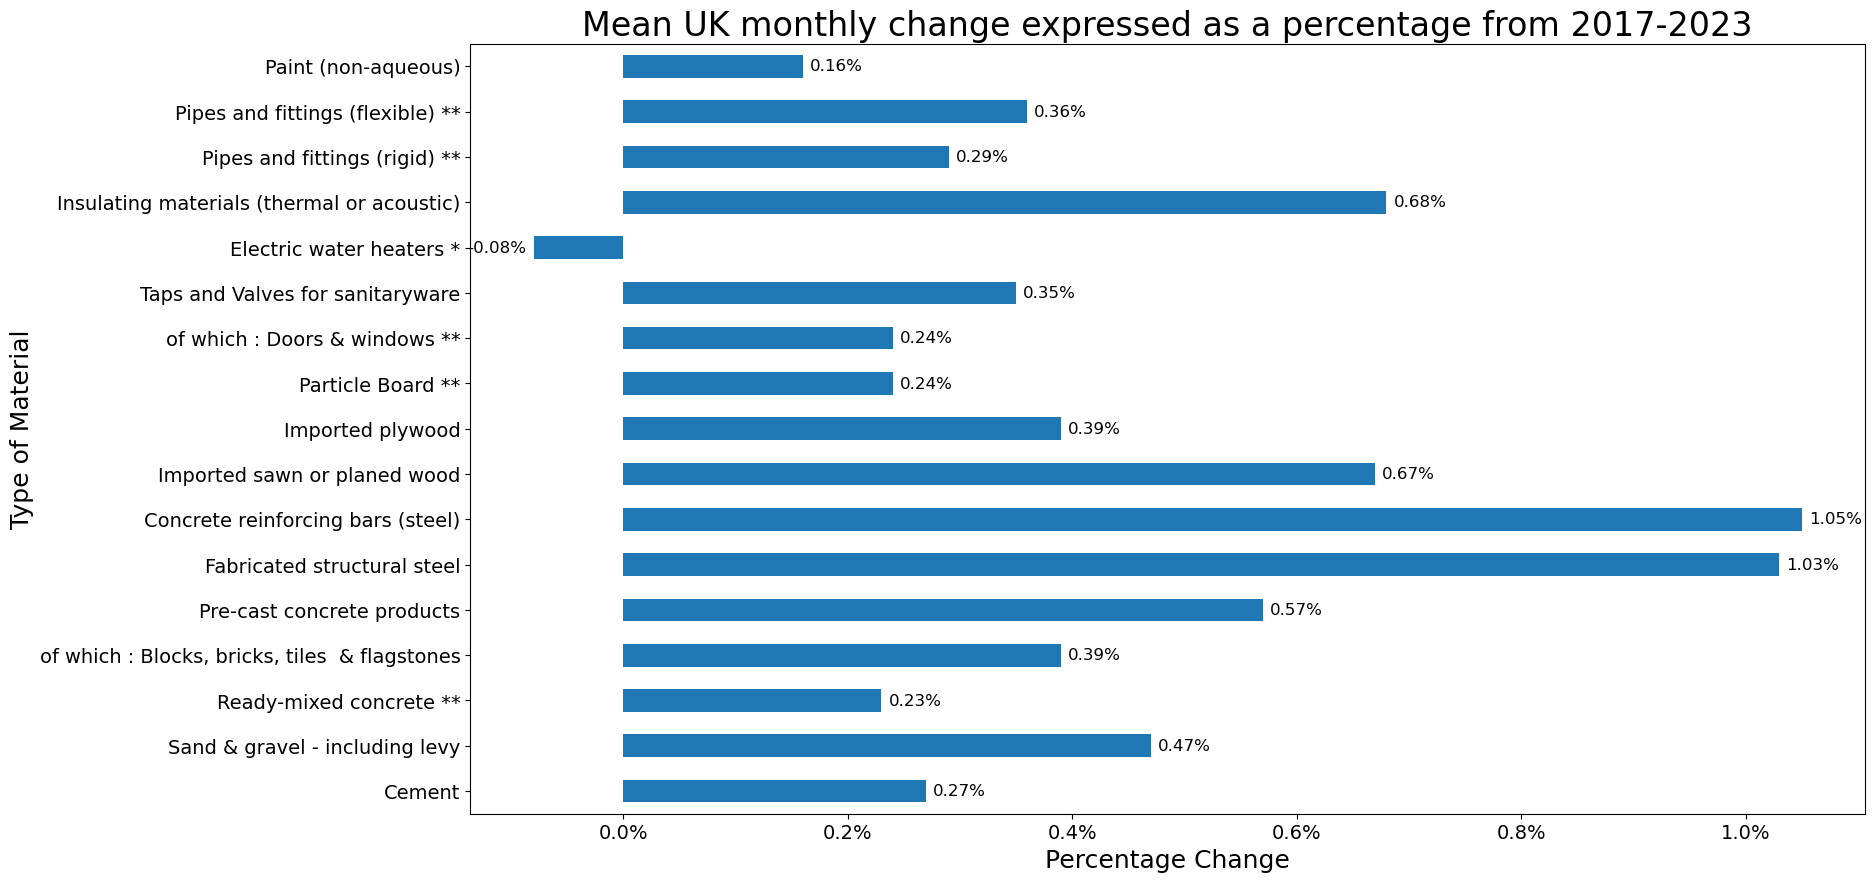

In [61]:
uk_avg_monthly_pct_change = round(uk_avg_monthly_pct_change.mean(), 2)

plt.figure(figsize=(18,10))
ax = uk_avg_monthly_pct_change.plot.barh()

plt.title("Mean UK monthly change expressed as a percentage from 2017-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])

plt.bar_label(ax.containers[0], padding = 5 , size=12 , fmt='%.2f%%')

In [267]:
uk_avg_monthly_pct_change.sort_values(ascending = False).to_frame()

0
Type of Material                                    
Concrete reinforcing bars (steel)               1.05
Fabricated structural steel                     1.03
Insulating materials (thermal or acoustic)      0.68
Imported sawn or planed wood                    0.67
Pre-cast concrete products                      0.57
Sand & gravel - including levy                  0.47
Imported plywood                                0.39
of which : Blocks, bricks, tiles  & flagstones  0.39
Pipes and fittings (flexible) **                0.36
Taps and Valves for sanitaryware                0.35
Pipes and fittings (rigid) **                   0.29
Cement                                          0.27
of which : Doors & windows **                   0.24
Particle Board **                               0.24
Ready-mixed concrete **                         0.23
Paint (non-aqueous)                             0.16
Electric water heaters *                       -0.08

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_56195/1543705472.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])


[Text(5, 0, '3.24%'),
 Text(5, 0, '5.64%'),
 Text(5, 0, '2.76%'),
 Text(5, 0, '4.68%'),
 Text(5, 0, '6.84%'),
 Text(5, 0, '12.36%'),
 Text(5, 0, '12.60%'),
 Text(5, 0, '8.04%'),
 Text(5, 0, '4.68%'),
 Text(5, 0, '2.88%'),
 Text(5, 0, '2.88%'),
 Text(5, 0, '4.20%'),
 Text(-5, 0, '-0.96%'),
 Text(5, 0, '8.16%'),
 Text(5, 0, '3.48%'),
 Text(5, 0, '4.32%'),
 Text(5, 0, '1.92%')]

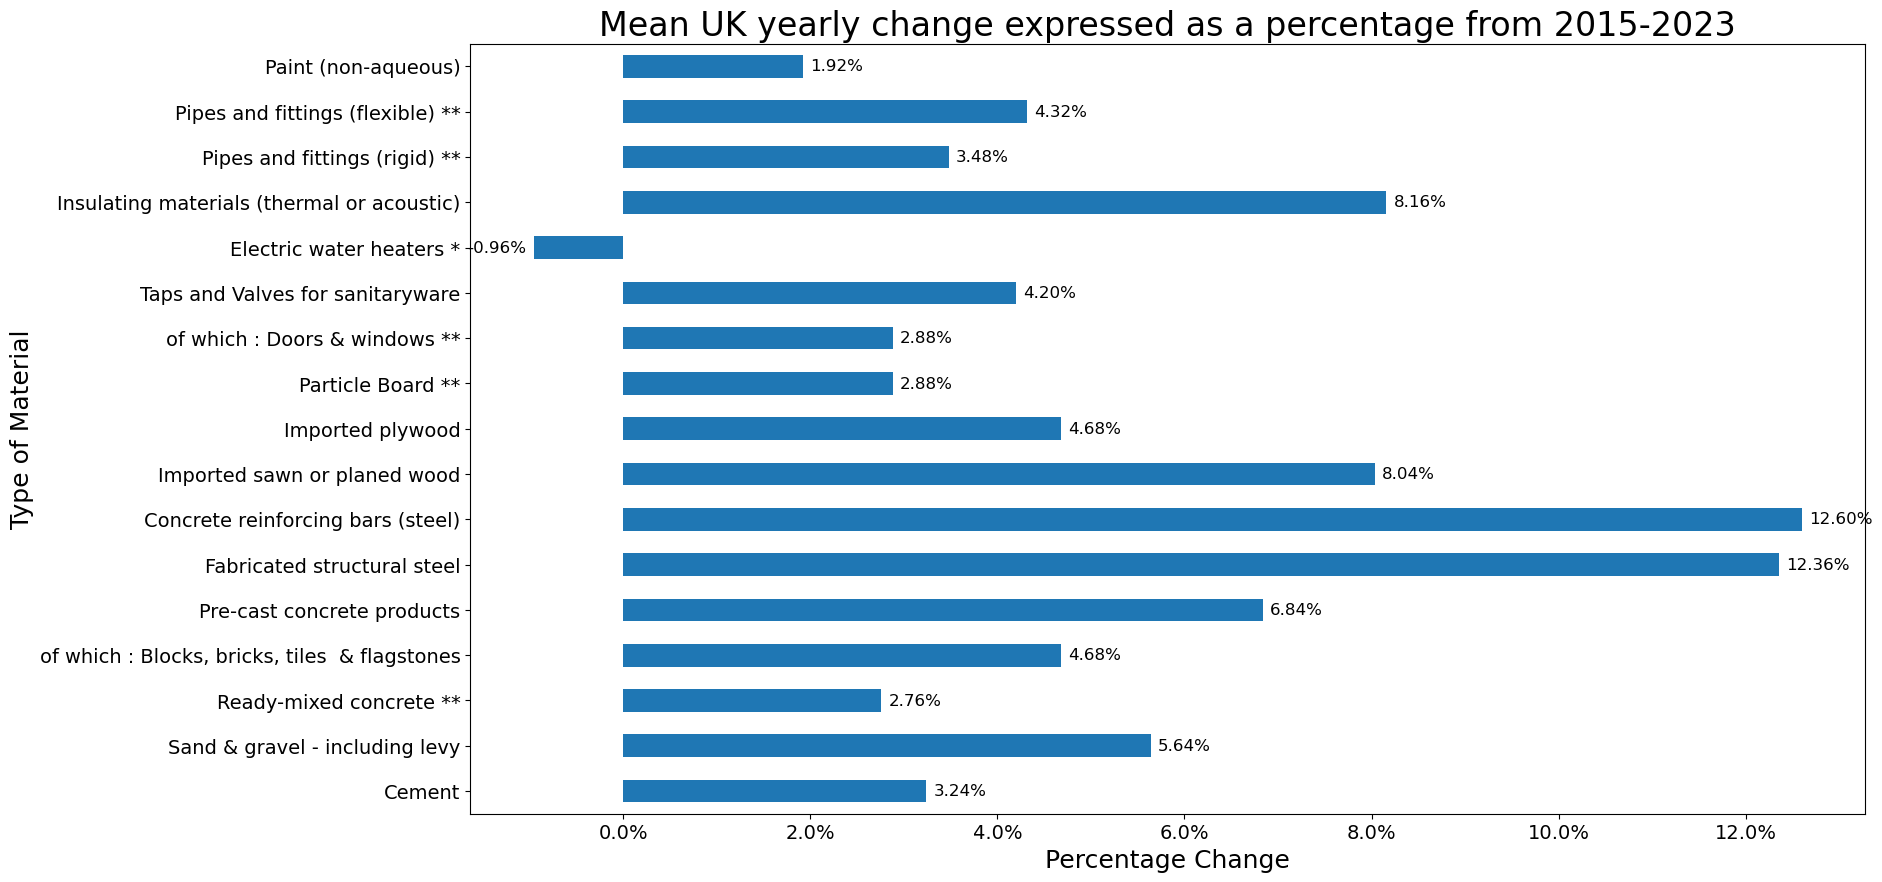

In [63]:
uk_avg_yearly_pct_change = uk_avg_monthly_pct_change * 12

plt.figure(figsize=(18,10))
ax = uk_avg_yearly_pct_change.plot.barh()

plt.title("Mean UK yearly change expressed as a percentage from 2015-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])

plt.bar_label(ax.containers[0], padding = 5 , size=12 , fmt='%.2f%%')

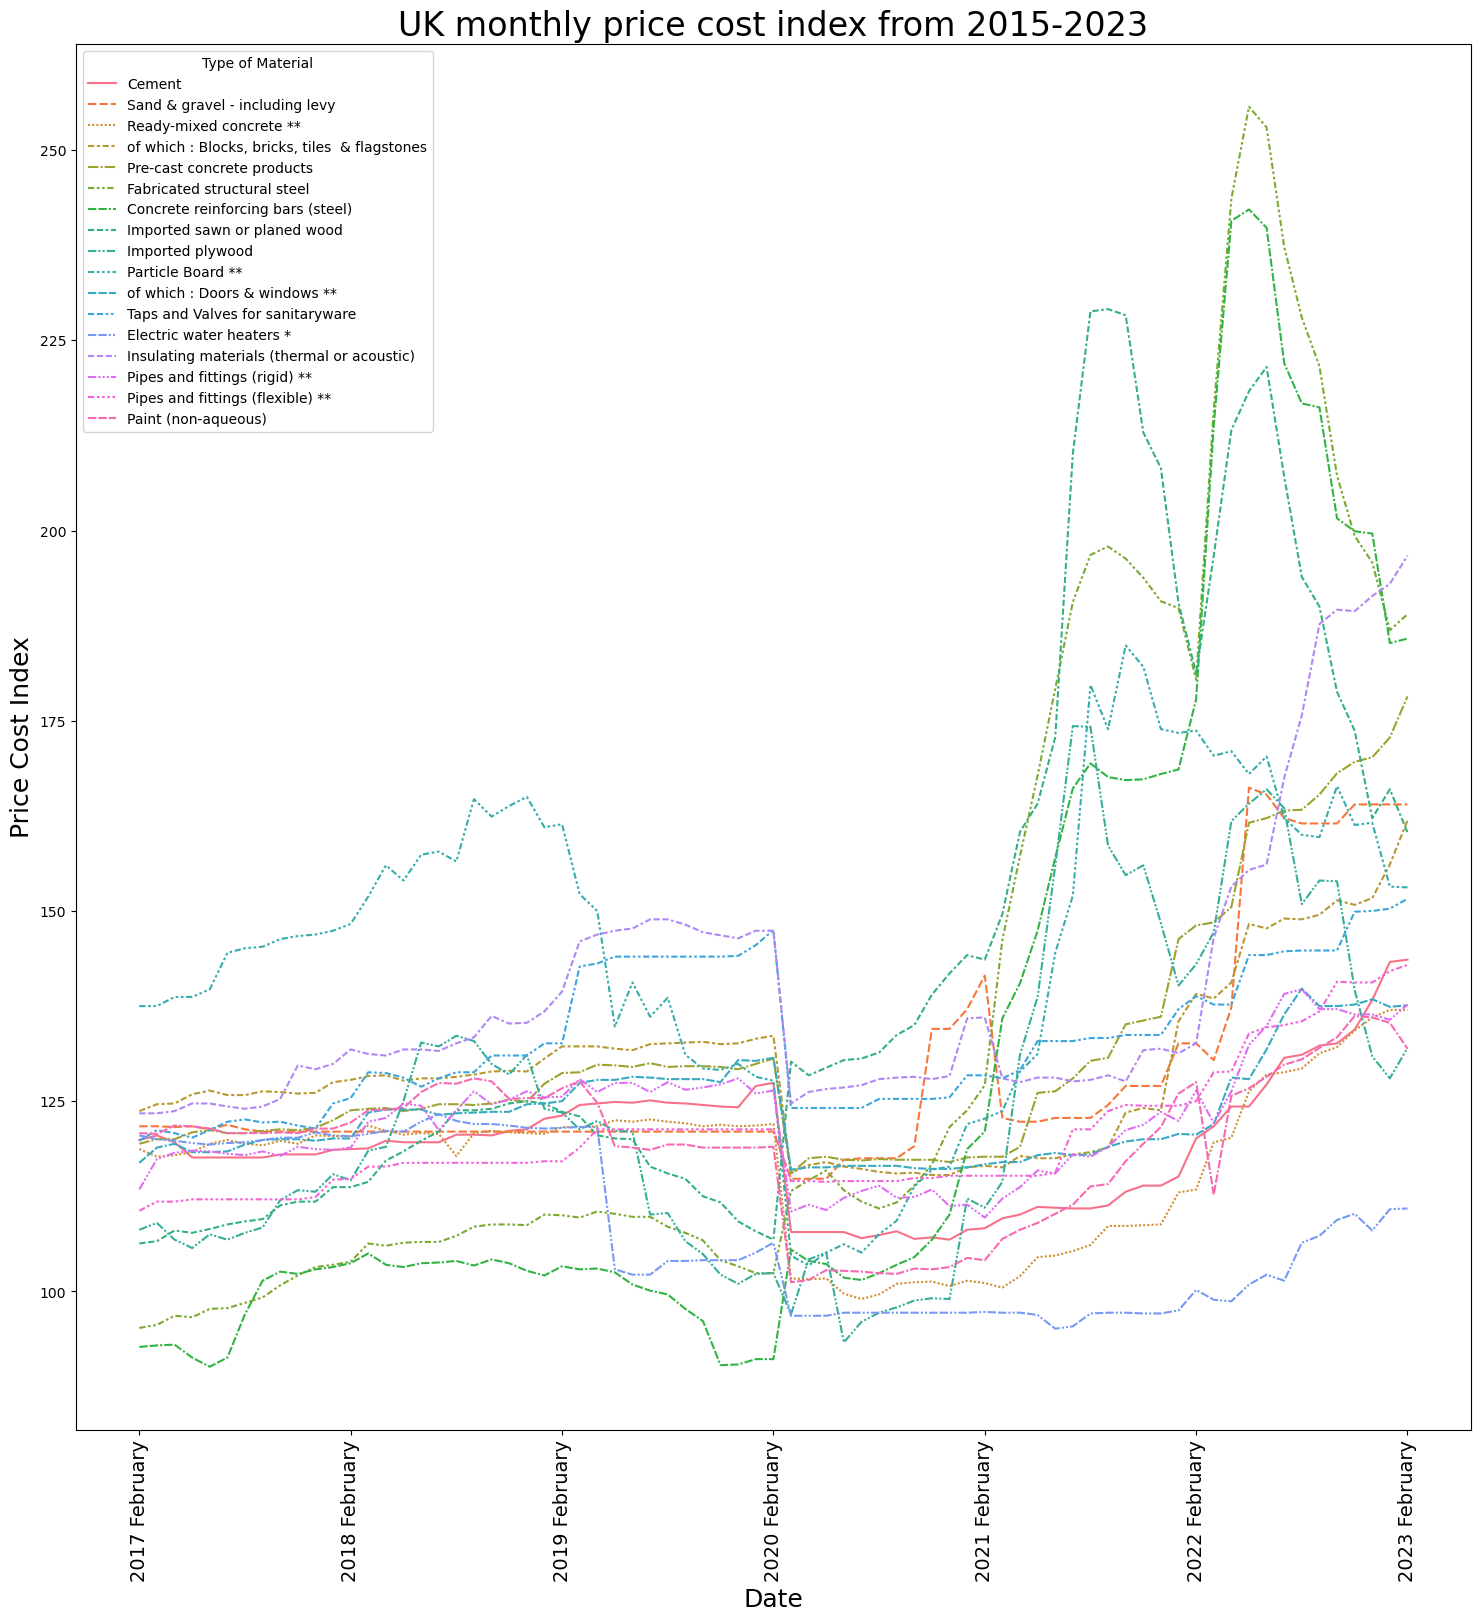

In [396]:
plt.figure(figsize=(18,18))

sns_plot = sns.lineplot(data = new_uk_df , ci = None)

plt.title("UK monthly price cost index from 2015-2023", fontsize="24")
plt.xlabel("Date", fontsize="18")
plt.ylabel("Price Cost Index", fontsize="18")
plt.xticks(plt.xticks()[0], rotation=90, size = 14)
sns_plot.xaxis.get_major_locator()  
sns_plot.xaxis.set_major_locator(ticker.MultipleLocator(12))

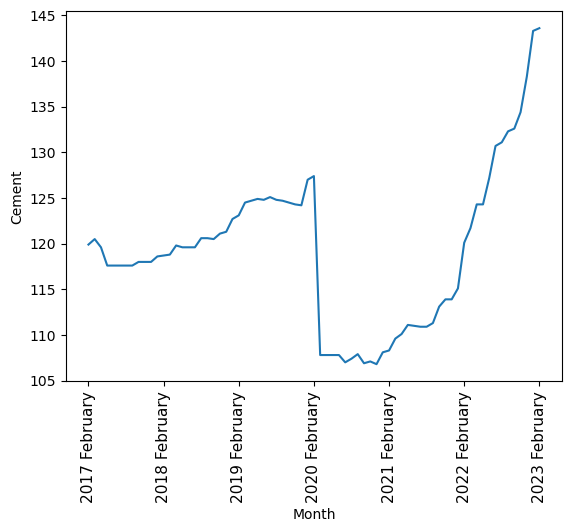

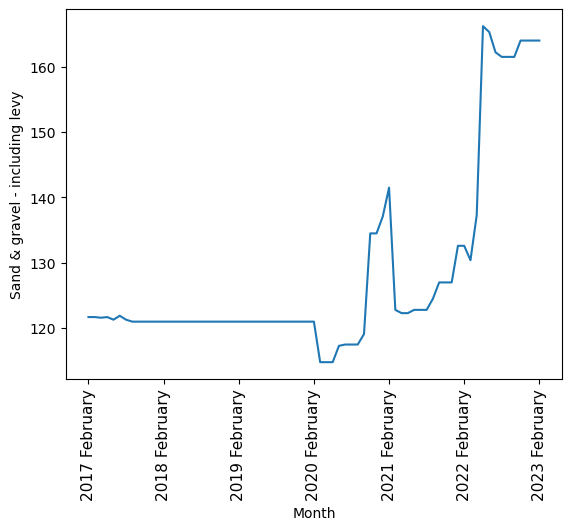

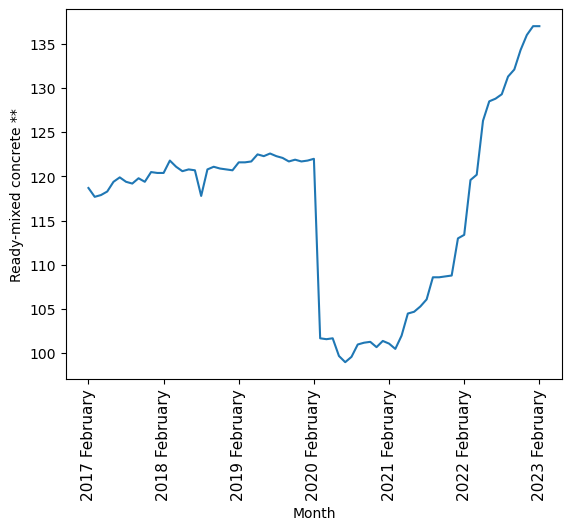

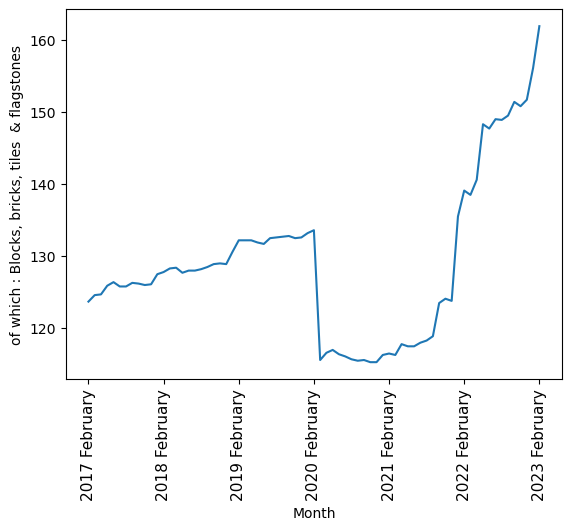

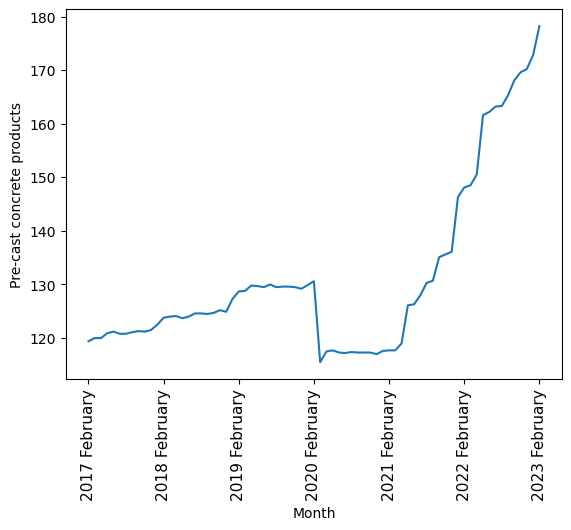

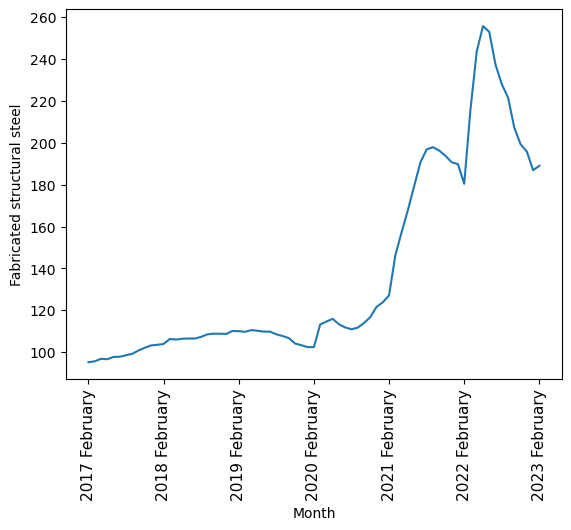

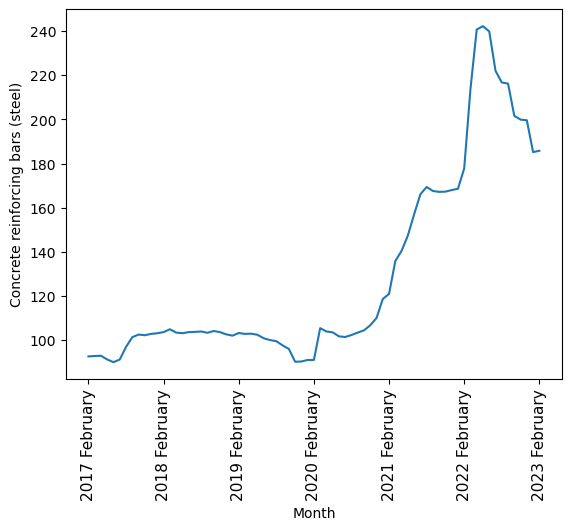

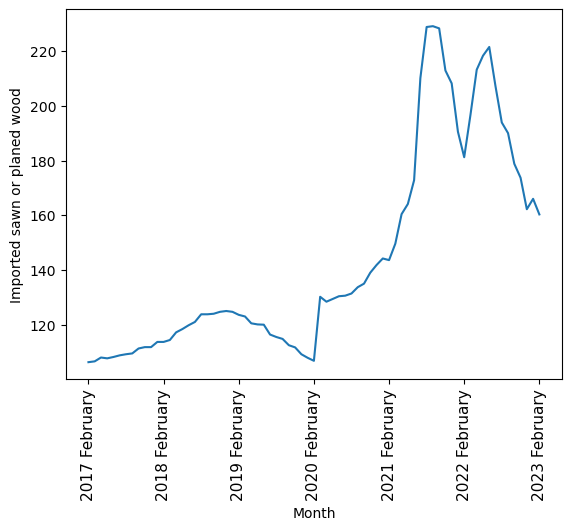

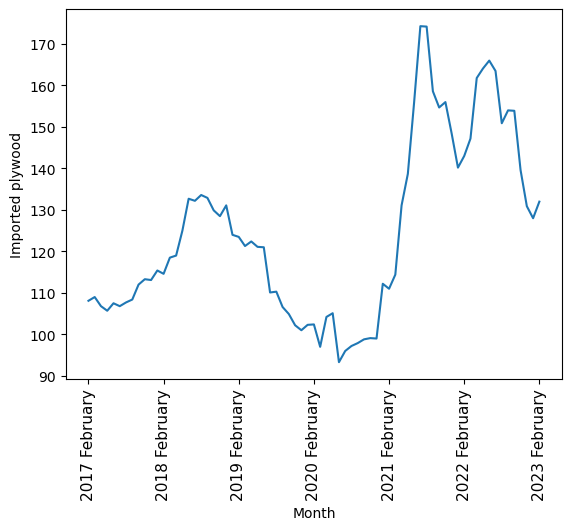

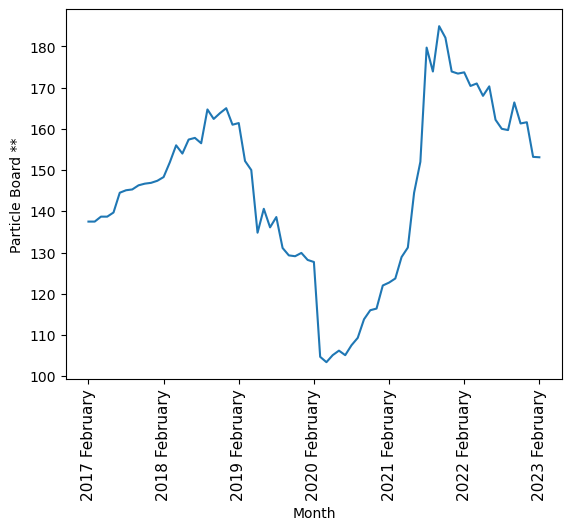

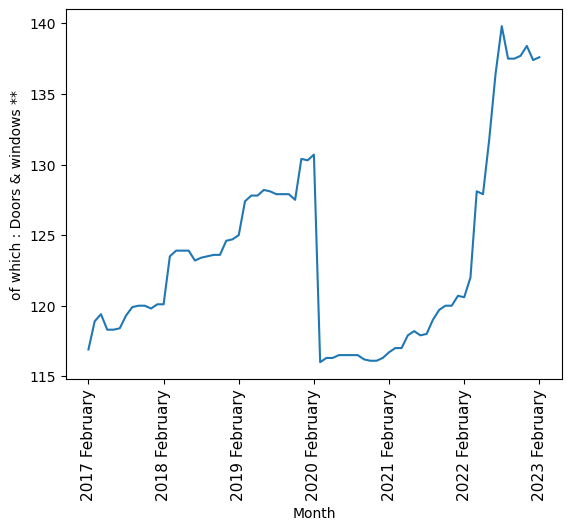

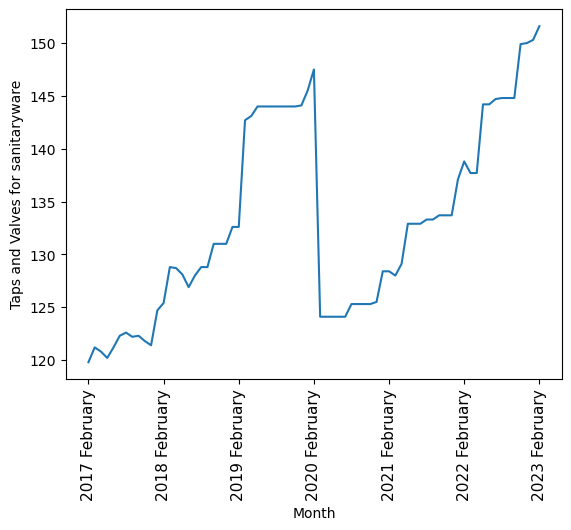

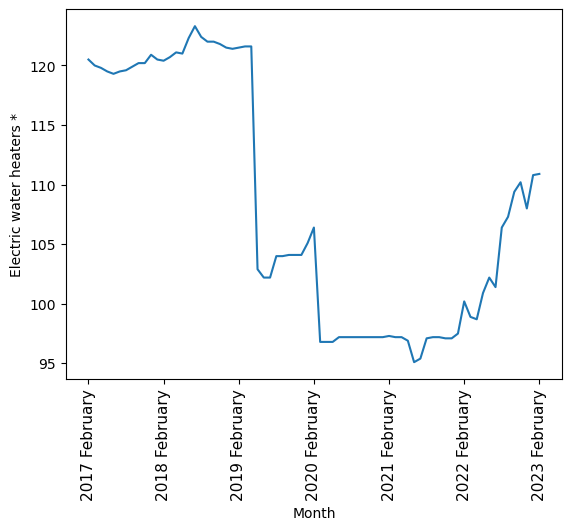

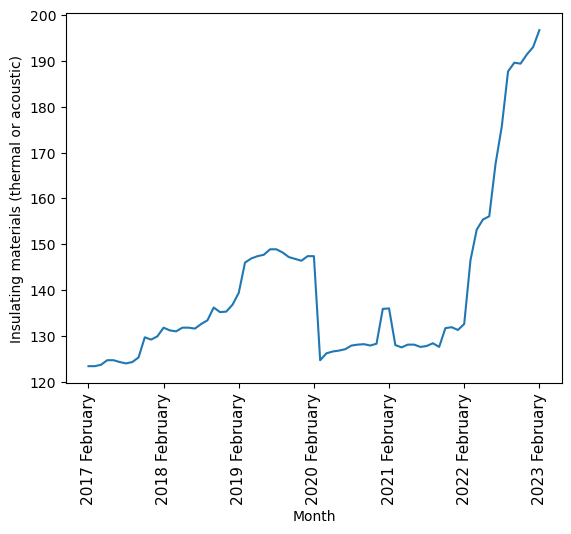

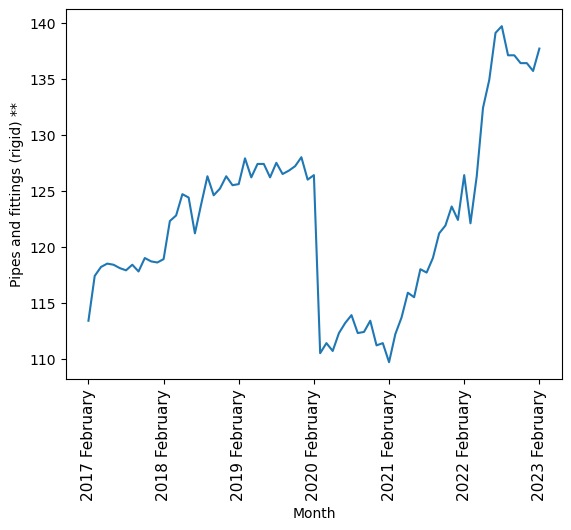

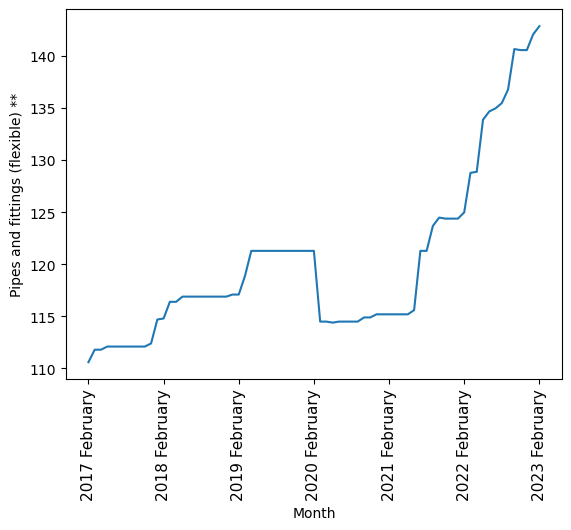

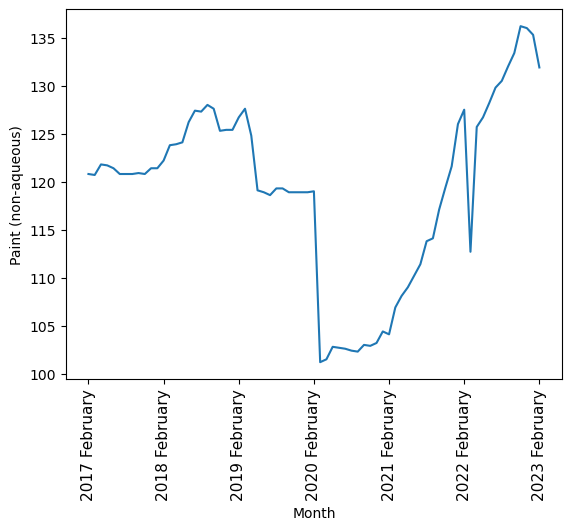

In [65]:
for i in new_uk_df.columns:
    plt.figure()
    plt.tight_layout()
    line_plot = sns.lineplot(data = new_uk_df,  x = new_uk_df.index, y = i)
    plt.xticks(plt.xticks()[0], rotation=90, size = 11)
    line_plot.xaxis.get_major_locator()  
    line_plot.xaxis.set_major_locator(ticker.MultipleLocator(12))

## Sentiment Analysis

In [ ]:
# API token access
reddit = praw.Reddit(user_agent="Comment Extraction (by /u/Additional_View_7692)",
                     client_id="RSFY_TaoLIHhcy0ah4pd3g", client_secret="VdOtRpaHUsJVh-9aSxISzK9icBoalw")

In [827]:
urls = [
    'https://www.reddit.com/r/ireland/comments/137gv6y/building_homes_in_dublin_costs_up_to_30_more_than/',
    'https://www.reddit.com/r/ireland/comments/10llx2a/ireland_may_need_up_to_62000_new_homes_a_year/',
    'https://www.reddit.com/r/ireland/comments/so7o4z/is_building_a_house_cheaper_than_buying/',
    'https://www.reddit.com/r/irishpersonalfinance/comments/10b3ize/cost_of_building_a_new_house_i_heard_200_per_sq/',
    'https://www.reddit.com/r/ireland/comments/uwl9ul/rising_cost_of_building_materials_is_getting/',
    'https://www.reddit.com/r/ireland/comments/pxx6rx/whats_behind_the_soaring_cost_of_construction/',
    'UK',
    'https://www.reddit.com/r/unitedkingdom/comments/n7kflf/cost_of_building_work_on_uk_homes_to_rise_as/',
    'https://www.reddit.com/r/AskUK/comments/xsqn6s/crafty_people_of_the_uk_where_do_you_get_timber/',
    'https://www.reddit.com/r/UKInvesting/comments/n14euv/uk_builders_to_suffer_from_material_shortage/',
    'https://www.reddit.com/r/Construction/comments/rxieau/uk_construction_cost_inflation/',
    'https://www.reddit.com/r/Infographics/comments/nlrint/cost_of_building_materials_2021_vs_2021/'
]

Final_sentiment_list = ['Source', 'Topic', 'Sentiment']
Final_sentiment_scores = []

topic = 'IE'
for url in urls:
    if url == 'UK':
        # If we reach the point in the links that are related to UK, switch topic label to reflect this
        topic = 'UK'
        continue
        
    # Reddit API request for link
    submission = reddit.submission(url=url)
    
    # Get all comments on post, Replies to original comments are not included
    posts = []
    for top_level_comment in submission.comments[1:]:
        if isinstance(top_level_comment, MoreComments):
            continue
        posts.append(top_level_comment.body)
    posts = pd.DataFrame(posts,columns=["comment"])
    
    # Data cleaning: remove deleted or removed posts
    indexNames = posts[(posts.comment == '[removed]') | (posts.comment == '[deleted]')].index
    posts.drop(indexNames, inplace=True)
    
    # Analyze the comment
    sid_obj= SentimentIntensityAnalyzer()
    comments_lst = ['Neg', 'Neutral', 'Positive', 'Compound']
    com_scores = []

    for comment in posts['comment']:
        x = sid_obj.polarity_scores(comment)
        x = list(x.values())
        com_scores.append([x[0], x[1], x[2], x[3]])
    
    # Store comments sentiment values in a new df
    sentiment_df = pd.DataFrame(com_scores, columns=comments_lst)
    sentiment_df = sentiment_df.mean().to_frame()
    print(url, ': ',round(sentiment_df.iloc[3 ,0], 3))
    
    # Store general sentiment of reddit discussion to evaluate vs other links
    Final_sentiment_scores.append([url , topic, round(sentiment_df.iloc[3 ,0], 3)])
    
# Create dataframe of link sentiment scores
Post_Sentiment = pd.DataFrame(Final_sentiment_scores, columns=Final_sentiment_list)
# Using binning to convert floating point score to categorical data
# -1 is for most negative and +1 is for most positive.
Post_Sentiment['Sentiment'] = pd.cut(Post_Sentiment['Sentiment'], bins=[-1, -0.4, -0.1 ,0, 0.1, 0.4, 1, 2], labels=['Very Negative', 'Negative', 'Slightly Negative', 'Neutral', 'Slightly Positive', 'Positve', 'Very Positive'])
Post_Sentiment

https://www.reddit.com/r/ireland/comments/137gv6y/building_homes_in_dublin_costs_up_to_30_more_than/ :  0.09
https://www.reddit.com/r/ireland/comments/10llx2a/ireland_may_need_up_to_62000_new_homes_a_year/ :  0.162
https://www.reddit.com/r/ireland/comments/so7o4z/is_building_a_house_cheaper_than_buying/ :  0.317
https://www.reddit.com/r/irishpersonalfinance/comments/10b3ize/cost_of_building_a_new_house_i_heard_200_per_sq/ :  0.374
https://www.reddit.com/r/ireland/comments/uwl9ul/rising_cost_of_building_materials_is_getting/ :  0.071
https://www.reddit.com/r/ireland/comments/pxx6rx/whats_behind_the_soaring_cost_of_construction/ :  -0.328
https://www.reddit.com/r/unitedkingdom/comments/n7kflf/cost_of_building_work_on_uk_homes_to_rise_as/ :  0.186
https://www.reddit.com/r/AskUK/comments/xsqn6s/crafty_people_of_the_uk_where_do_you_get_timber/ :  0.374
https://www.reddit.com/r/UKInvesting/comments/n14euv/uk_builders_to_suffer_from_material_shortage/ :  0.073
https://www.reddit.com/r/Constru

Source Topic          Sentiment
0   https://www.reddit.com/r/ireland/comments/137g...    IE            Neutral
1   https://www.reddit.com/r/ireland/comments/10ll...    IE  Slightly Positive
2   https://www.reddit.com/r/ireland/comments/so7o...    IE  Slightly Positive
3   https://www.reddit.com/r/irishpersonalfinance/...    IE  Slightly Positive
4   https://www.reddit.com/r/ireland/comments/uwl9...    IE            Neutral
5   https://www.reddit.com/r/ireland/comments/pxx6...    IE           Negative
6   https://www.reddit.com/r/unitedkingdom/comment...    UK  Slightly Positive
7   https://www.reddit.com/r/AskUK/comments/xsqn6s...    UK  Slightly Positive
8   https://www.reddit.com/r/UKInvesting/comments/...    UK            Neutral
9   https://www.reddit.com/r/Construction/comments...    UK            Positve
10  https://www.reddit.com/r/Infographics/comments...    UK  Slightly Negative

### Statistical Evaluations 

In [67]:
# Test for any correllations between IE and UK data. 
# List of irish materials in descending order
ie_stat_test = ie_avg_monthly_pct_change.sort_values(ascending = False)
ie_stat_test = ie_stat_test.to_frame().index.to_list()

#### Run a for loop for all Statistical Tests

In [428]:
IE_Shapiro_cols = ['IE Material' , ' P-Value']
IE_Shapiro_lst = []

UK_Shapiro_cols = ['UK Material' , ' P-Value']
UK_Shapiro_lst = []

Levene_cols = ['IE Material' , 'UK Material', 'Statistic', ' P-value']
Levene_lst = []

TT_cols = ['IE Material' , 'UK Material', 'T-Statistic', ' P-Value']
TT_lst = []

Pearson_cols = ['IE Material' , 'UK Material', 'Correlation Coefficient', ' P-value']
Pearson_lst = []

IE_adfuller_cols = ['IE Material' , 'Test Statistic', ' P-value']
IE_adfuller_lst = []

UK_adfuller_cols = ['UK Material' , 'Test Statistic', ' P-value']
UK_adfuller_lst = []

for stat in ie_stat_test:
    # Shapiro
    Shap_test_ie = shapiro(new_ie_df[stat])
    IE_Shapiro_lst.append([stat, round(Shap_test_ie[1], 4)])
    
    Shap_test_uk = shapiro(new_uk_df[common_list_dict[stat]])
    UK_Shapiro_lst.append([common_list_dict[stat], round(Shap_test_uk[1], 4)])
    
    # Levene's Test
    Levene_test = stats.levene(new_ie_df[stat], new_uk_df[common_list_dict[stat]], center='median')
    Levene_lst.append([stat, common_list_dict[stat], round(Levene_test[0], 3), round(Levene_test[1], 4)])
    
    # Welch’s t-test
    t_test = stats.ttest_ind(new_ie_df[stat], new_uk_df[common_list_dict[stat]], equal_var = False)
    TT_lst.append([stat, common_list_dict[stat], round(t_test[0], 3), round(t_test[1], 4)])
    
    # Pearson requires equal sample sizes, we trim the bigger sample to match the smaller one in date & size using .tail()
    product = new_ie_df[stat]
    moment = new_uk_df[common_list_dict[stat]]
    pearson_test = pearsonr(product.tail(len(moment)), moment)
    Pearson_lst.append([stat, common_list_dict[stat], round(pearson_test[0], 3), round(pearson_test[1], 4)])
    
    # Augmented Dickey-Fuller
    ie_adfuller_test = adfuller(new_ie_df[stat])
    IE_adfuller_lst.append([stat, round(ie_adfuller_test[0], 3), round(ie_adfuller_test[1], 4)])
    
    uk_adfuller_test = adfuller(new_uk_df[common_list_dict[stat]])
    UK_adfuller_lst.append([common_list_dict[stat], round(uk_adfuller_test[0], 3), round(uk_adfuller_test[1], 4)])

#### Shapiro Wilks Test

In [419]:
IE_Shap_df = pd.DataFrame(IE_Shapiro_lst, columns=IE_Shapiro_cols)
IE_Shap_df

IE Material   P-Value
0                         Other treated timber    0.0000
1            Structural steel fabricated metal    0.0000
2          Machined, treated engineered timber    0.0000
3                            Reinforcing metal    0.0000
4                                       Cement    0.0000
5          Rough timber (including plain sawn)    0.0000
6                   Paints, oils and varnishes    0.0000
7   Plumbing materials including sanitary ware    0.0000
8                           Pipes and fittings    0.0000
9                    Copper pipes and fittings    0.0000
10                             Sand and gravel    0.0313
11             Ready mixed mortar and concrete    0.0000
12                    Wooden windows and doors    0.0000
13   Other concrete products including precast    0.0000
14                  Concrete blocks and bricks    0.0000
15                        Insulating materials    0.0000
16    HVAC (heating and ventilation equipment)    0.0000

In [420]:
UK_Shap_df = pd.DataFrame(UK_Shapiro_lst, columns=UK_Shapiro_cols)
UK_Shap_df

UK Material   P-Value
0                                Particle Board **    0.0648
1                      Fabricated structural steel    0.0000
2                                 Imported plywood    0.0005
3                Concrete reinforcing bars (steel)    0.0000
4                                           Cement    0.0030
5                     Imported sawn or planed wood    0.0000
6                              Paint (non-aqueous)    0.0004
7                 Taps and Valves for sanitaryware    0.0001
8                 Pipes and fittings (flexible) **    0.0000
9                    Pipes and fittings (rigid) **    0.0062
10                  Sand & gravel - including levy    0.0000
11                         Ready-mixed concrete **    0.0000
12                   of which : Doors & windows **    0.0000
13                      Pre-cast concrete products    0.0000
14  of which : Blocks, bricks, tiles  & flagstones    0.0000
15      Insulating materials (thermal or acoustic)    0.0000
16                        Electric water heaters *    0.0000

#### Levene’s Test

In [429]:
Levene_df = pd.DataFrame(Levene_lst, columns=Levene_cols)
Levene_df

IE Material  \
0                         Other treated timber   
1            Structural steel fabricated metal   
2          Machined, treated engineered timber   
3                            Reinforcing metal   
4                                       Cement   
5          Rough timber (including plain sawn)   
6                   Paints, oils and varnishes   
7   Plumbing materials including sanitary ware   
8                           Pipes and fittings   
9                    Copper pipes and fittings   
10                             Sand and gravel   
11             Ready mixed mortar and concrete   
12                    Wooden windows and doors   
13   Other concrete products including precast   
14                  Concrete blocks and bricks   
15                        Insulating materials   
16    HVAC (heating and ventilation equipment)   

                                       UK Material  Statistic   P-value  
0                                Particle Board **      1.959    0.1635  
1                      Fabricated structural steel      9.552    0.0023  
2                                 Imported plywood      0.840    0.3607  
3                Concrete reinforcing bars (steel)      4.501    0.0353  
4                                           Cement     20.224    0.0000  
5                     Imported sawn or planed wood      5.866    0.0165  
6                              Paint (non-aqueous)     14.971    0.0002  
7                 Taps and Valves for sanitaryware      0.234    0.6295  
8                 Pipes and fittings (flexible) **      2.420    0.1217  
9                    Pipes and fittings (rigid) **      0.431    0.5124  
10                  Sand & gravel - including levy      0.247    0.6200  
11                         Ready-mixed concrete **      0.418    0.5186  
12                   of which : Doors & windows **      2.664    0.1045  
13                      Pre-cast concrete products      9.673    0.0022  
14  of which : Blocks, bricks, tiles  & flagstones     11.453    0.0009  
15      Insulating materials (thermal or acoustic)     13.957    0.0003  
16                        Electric water heaters *     60.161    0.0000

#### Welch’s T-test

In [114]:
TT_df = pd.DataFrame(TT_lst, columns=TT_cols)
TT_df

IE Material  \
0                         Other treated timber   
1            Structural steel fabricated metal   
2          Machined, treated engineered timber   
3                            Reinforcing metal   
4                                       Cement   
5          Rough timber (including plain sawn)   
6                   Paints, oils and varnishes   
7   Plumbing materials including sanitary ware   
8                           Pipes and fittings   
9                    Copper pipes and fittings   
10                             Sand and gravel   
11             Ready mixed mortar and concrete   
12                    Wooden windows and doors   
13   Other concrete products including precast   
14                  Concrete blocks and bricks   
15                        Insulating materials   
16    HVAC (heating and ventilation equipment)   

                                       UK Material  T-Statistic   P-Value  
0                                Particle Board **       -4.736    0.0000  
1                      Fabricated structural steel       -1.649    0.1018  
2                                 Imported plywood       -2.705    0.0075  
3                Concrete reinforcing bars (steel)       -1.649    0.1017  
4                                           Cement       -1.108    0.2699  
5                     Imported sawn or planed wood       -4.420    0.0000  
6                              Paint (non-aqueous)       -1.958    0.0519  
7                 Taps and Valves for sanitaryware      -14.388    0.0000  
8                 Pipes and fittings (flexible) **       -6.453    0.0000  
9                    Pipes and fittings (rigid) **       -9.924    0.0000  
10                  Sand & gravel - including levy       -6.488    0.0000  
11                         Ready-mixed concrete **       -5.663    0.0000  
12                   of which : Doors & windows **      -10.270    0.0000  
13                      Pre-cast concrete products      -11.992    0.0000  
14  of which : Blocks, bricks, tiles  & flagstones      -15.696    0.0000  
15      Insulating materials (thermal or acoustic)      -14.177    0.0000  
16                        Electric water heaters *       -2.622    0.0102

#### Pearson Correlation

In [117]:
Pearson_df = pd.DataFrame(Pearson_lst, columns=Pearson_cols)
Pearson_df

IE Material  \
0                         Other treated timber   
1            Structural steel fabricated metal   
2          Machined, treated engineered timber   
3                            Reinforcing metal   
4                                       Cement   
5          Rough timber (including plain sawn)   
6                   Paints, oils and varnishes   
7   Plumbing materials including sanitary ware   
8                           Pipes and fittings   
9                    Copper pipes and fittings   
10                             Sand and gravel   
11             Ready mixed mortar and concrete   
12                    Wooden windows and doors   
13   Other concrete products including precast   
14                  Concrete blocks and bricks   
15                        Insulating materials   
16    HVAC (heating and ventilation equipment)   

                                       UK Material  Correlation Coefficient  \
0                                Particle Board **                    0.617   
1                      Fabricated structural steel                    0.773   
2                                 Imported plywood                    0.759   
3                Concrete reinforcing bars (steel)                    0.984   
4                                           Cement                    0.494   
5                     Imported sawn or planed wood                    0.960   
6                              Paint (non-aqueous)                    0.219   
7                 Taps and Valves for sanitaryware                    0.668   
8                 Pipes and fittings (flexible) **                    0.928   
9                    Pipes and fittings (rigid) **                    0.679   
10                  Sand & gravel - including levy                    0.562   
11                         Ready-mixed concrete **                    0.501   
12                   of which : Doors & windows **                    0.670   
13                      Pre-cast concrete products                    0.918   
14  of which : Blocks, bricks, tiles  & flagstones                    0.781   
15      Insulating materials (thermal or acoustic)                    0.774   
16                        Electric water heaters *                   -0.380   

     P-value  
0     0.0000  
1     0.0000  
2     0.0000  
3     0.0000  
4     0.0000  
5     0.0000  
6     0.0628  
7     0.0000  
8     0.0000  
9     0.0000  
10    0.0000  
11    0.0000  
12    0.0000  
13    0.0000  
14    0.0000  
15    0.0000  
16    0.0009

#### Augmented Dickey-Fuller Test

In [118]:
IE_adfuller_df = pd.DataFrame(IE_adfuller_lst, columns=IE_adfuller_cols)
IE_adfuller_df

IE Material  Test Statistic   P-value
0                         Other treated timber          -0.060    0.9532
1            Structural steel fabricated metal           1.050    0.9948
2          Machined, treated engineered timber           0.620    0.9881
3                            Reinforcing metal          -0.478    0.8962
4                                       Cement           4.121    1.0000
5          Rough timber (including plain sawn)          -1.171    0.6859
6                   Paints, oils and varnishes           2.375    0.9990
7   Plumbing materials including sanitary ware           2.265    0.9989
8                           Pipes and fittings           1.356    0.9969
9                    Copper pipes and fittings           2.236    0.9989
10                             Sand and gravel          -2.611    0.0908
11             Ready mixed mortar and concrete          -1.624    0.4704
12                    Wooden windows and doors           0.877    0.9928
13   Other concrete products including precast           0.697    0.9898
14                  Concrete blocks and bricks           0.122    0.9676
15                        Insulating materials           1.589    0.9978
16    HVAC (heating and ventilation equipment)           0.654    0.9889

In [119]:
UK_adfuller_df = pd.DataFrame(UK_adfuller_lst, columns=UK_adfuller_cols)
UK_adfuller_df

UK Material  Test Statistic   P-value
0                                Particle Board **          -1.936    0.3151
1                      Fabricated structural steel          -2.561    0.1014
2                                 Imported plywood          -1.777    0.3919
3                Concrete reinforcing bars (steel)          -2.373    0.1494
4                                           Cement           0.234    0.9741
5                     Imported sawn or planed wood          -1.575    0.4961
6                              Paint (non-aqueous)          -1.267    0.6441
7                 Taps and Valves for sanitaryware          -1.237    0.6576
8                 Pipes and fittings (flexible) **           1.388    0.9971
9                    Pipes and fittings (rigid) **          -1.005    0.7513
10                  Sand & gravel - including levy          -0.294    0.9263
11                         Ready-mixed concrete **          -0.327    0.9216
12                   of which : Doors & windows **          -0.757    0.8313
13                      Pre-cast concrete products           2.098    0.9988
14  of which : Blocks, bricks, tiles  & flagstones           0.832    0.9921
15      Insulating materials (thermal or acoustic)           0.672    0.9893
16                        Electric water heaters *          -1.393    0.5854

## Machine Learning Models

In [430]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [431]:
X = new_ie_df.drop(columns = ['Ready mixed mortar and concrete'])

y = new_ie_df['Ready mixed mortar and concrete']

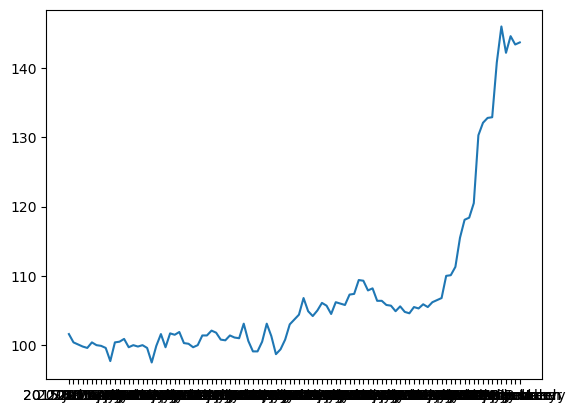

In [540]:
plt.plot(y)

#### Check if stationary

In [474]:
result=adfuller(y)

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

weak evidence against null hypothesis,indicating it is non-stationary 


#### LAG

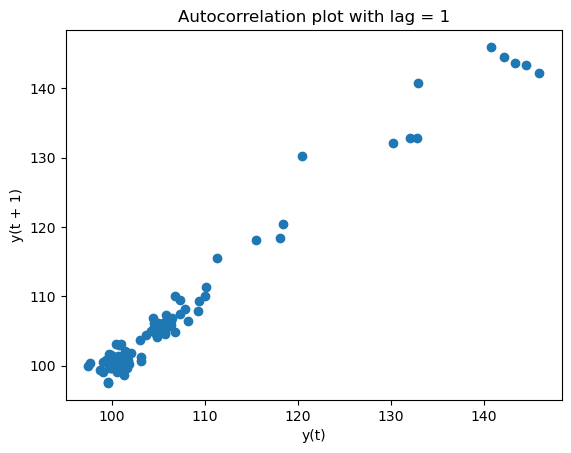

In [535]:
from pandas.plotting import lag_plot
plt.figure()
lag_plot(y, lag=1)
plt.title('Autocorrelation plot with lag = 1')
plt.show()

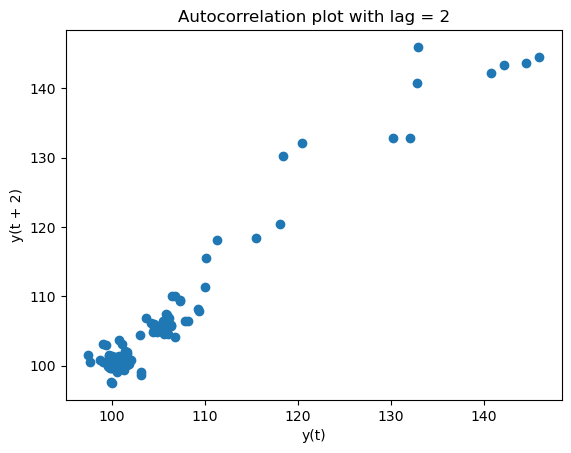

In [537]:
plt.figure()
lag_plot(y, lag=2)
plt.title('Autocorrelation plot with lag = 2')
plt.show()

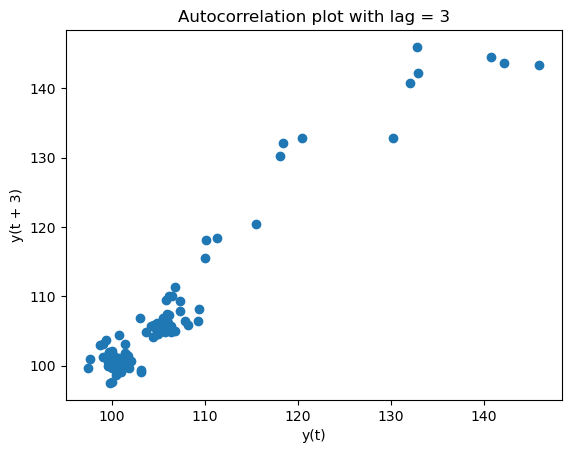

In [536]:
plt.figure()
lag_plot(y, lag=3)
plt.title('Autocorrelation plot with lag = 3')
plt.show()

#### Differencing & ACF

In [435]:
# Checking the p-value to see if differencing helps make data stationary at < 0.05 confidence
result = adfuller(y.dropna())
print('p-value: ', round(result[1], 3))

result = adfuller(y.diff().dropna())
print('p-value: ', round(result[1], 3))

result = adfuller(y.diff().diff().dropna())
print('p-value: ', round(result[1], 3))

p-value:  0.47
p-value:  0.311
p-value:  0.0


In [541]:
from statsmodels.graphics.tsaplots import plot_acf


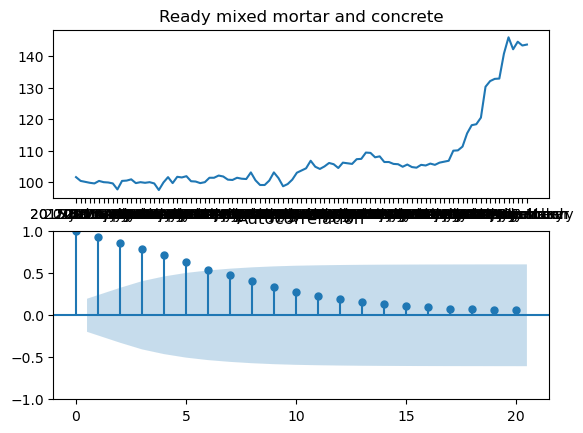

In [469]:
f = plt.figure ()
ax1 = f.add_subplot (2,1,1)
ax1.set_title('Ready mixed mortar and concrete')
ax1.plot(y)

ax2 = f.add_subplot (2,1,2)
plot_acf(y.dropna(), ax=ax2)
plt.show()

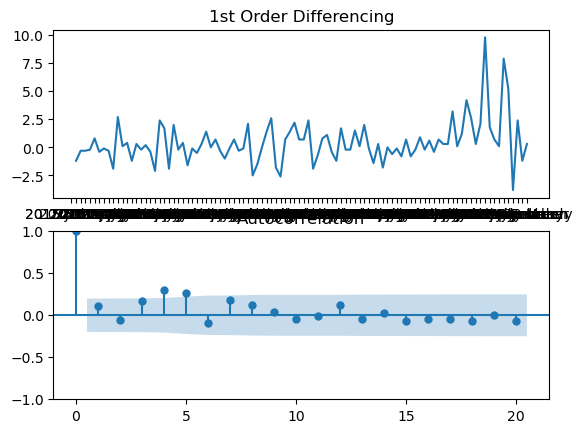

In [470]:
f = plt.figure ()
ax1 = f.add_subplot (2,1,1)
ax1.set_title('1st Order Differencing')
ax1.plot(y.diff())

ax2 = f.add_subplot (2,1,2)
plot_acf(y.diff().dropna(), ax=ax2)
plt.show()

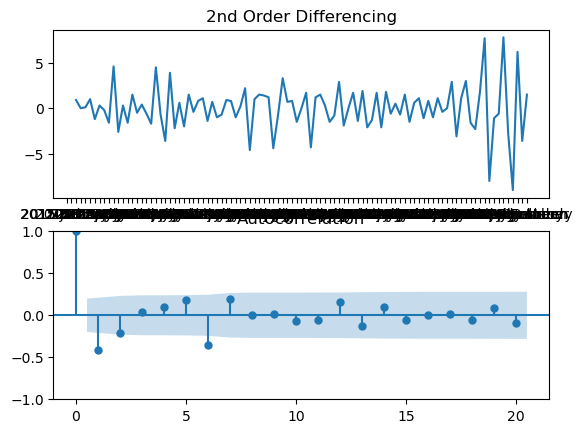

In [472]:
f = plt.figure ()
ax1 = f.add_subplot (2,1,1)
ax1.set_title('2nd Order Differencing')
ax1.plot(y.diff().diff())

ax2 = f.add_subplot (2,1,2)
plot_acf(y.diff().diff().dropna(), ax=ax2)
plt.show()

#### Model

The standard ARIMA models expect as input parameters 3 arguments i.e. p,d,q.

    p is the number of lag observations.
    d is the degree of differencing.
    q is the size/width of the moving average window.

In [675]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(y,order=(3,3,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     Ready mixed mortar and concrete   No. Observations:                   99
Model:                              ARIMA(3, 3, 4)   Log Likelihood                -195.595
Date:                             Fri, 26 May 2023   AIC                            407.189
Time:                                     13:51:19   BIC                            427.704
Sample:                                 01-01-2015   HQIC                           415.482
                                      - 03-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5237      0.411     -1.275      0.202      -1.329       0.281
ar.L2         -0.0939      0.221     -0.426      0.670      -0.526       0.338
ar.L3         -0.2538      0.191     -1.329      0.184      -0.628       0.121
ma.L1         -1.3599      0.960     -1.417      0.157      -3.241       0.521
ma.L2         -0.2084      0.735     -0.283      0.777      -1.650       1.233
ma.L3          1.0658      0.566      1.884      0.060      -0.043       2.175
ma.L4         -0.4967      0.512     -0.970      0.332      -1.500       0.507
sigma2         3.1513      2.347      1.343      0.179      -1.448       7.751
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                21.74
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               3.00   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

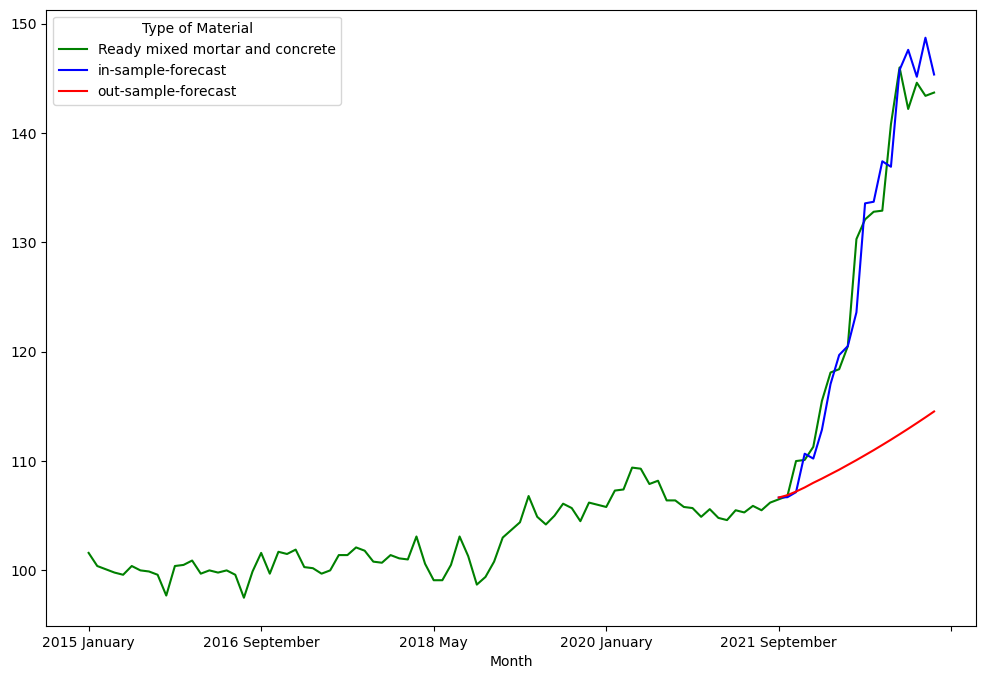

In [676]:
temp = new_ie_df

# In-sample prediction
temp['in-sample-forecast']=model_fit.predict(start=80,end=98,dynamic=False)
# Out-of-sample prediction
temp['out-sample-forecast']=model_fit.predict(start=80,end=98,dynamic=True)

temp[['Ready mixed mortar and concrete', 'in-sample-forecast', 'out-sample-forecast']].plot(figsize=(12,8), color=['green','blue', 'red'])




In [684]:
future_df_cols = ['Ready mixed mortar and concrete']
future_df = []
index_lst = ['2023 April', '2023 May', '2023 June', '2023 July', '2023 August', '2023 September', '2023 October', '2023 November', '2023 December', 
             '2024 January', '2024 February', '2024 March', '2024 April', '2024 May', '2024 June', '2024 July', '2024 August', '2024 September', '2024 October', '2024 November', '2024 December']    
for x in range(len(index_lst)):
    future_df.append([None])

past_df = new_ie_df['Ready mixed mortar and concrete'].to_frame()
future_df = pd.DataFrame(future_df, columns = future_df_cols, index = index_lst)
future_df=pd.concat([past_df,future_df])
future_df


Ready mixed mortar and concrete
2015 January                              101.6
2015 February                             100.4
2015 March                                100.1
2015 April                                 99.8
2015 May                                   99.6
...                                         ...
2024 August                                 NaN
2024 September                              NaN
2024 October                                NaN
2024 November                               NaN
2024 December                               NaN

[120 rows x 1 columns]

<AxesSubplot:>

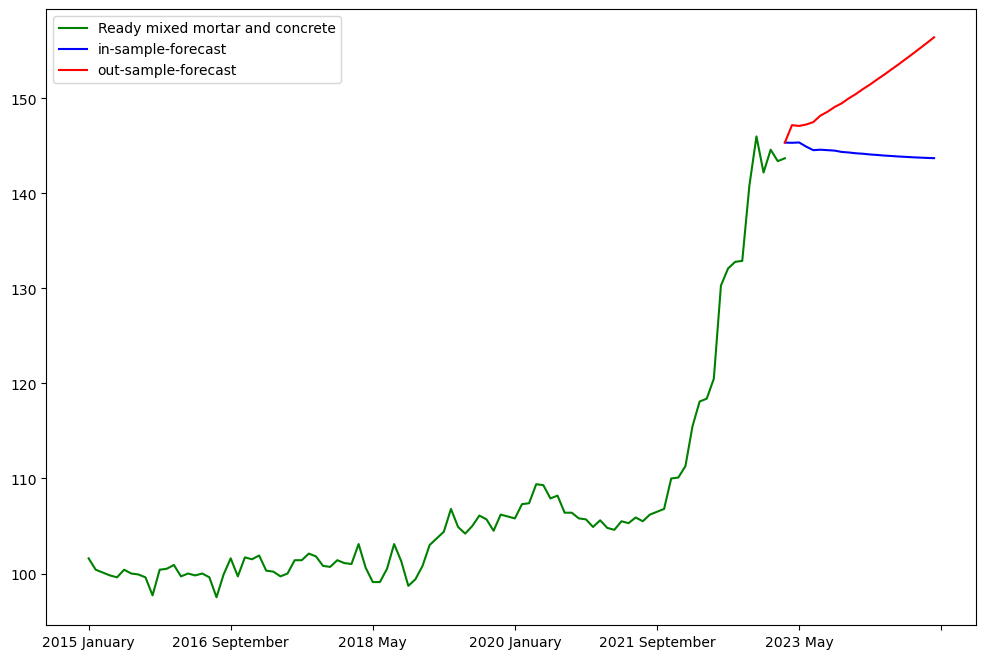

In [678]:
temp = future_df

# In-sample prediction
temp['in-sample-forecast']=model_fit.predict(start=98,end=150,dynamic=False)
# Out-of-sample prediction
temp['out-sample-forecast']=model_fit.predict(start=98,end=150,dynamic=True)

temp[['Ready mixed mortar and concrete', 'in-sample-forecast', 'out-sample-forecast']].plot(figsize=(12,8), color=['green','blue', 'red'])

In [679]:
temp

Ready mixed mortar and concrete  in-sample-forecast  \
2015 January                              101.6                 NaN   
2015 February                             100.4                 NaN   
2015 March                                100.1                 NaN   
2015 April                                 99.8                 NaN   
2015 May                                   99.6                 NaN   
...                                         ...                 ...   
2024 August                                 NaN          143.846627   
2024 September                              NaN          143.803467   
2024 October                                NaN          143.770444   
2024 November                               NaN          143.736601   
2024 December                               NaN          143.710620   

                out-sample-forecast  
2015 January                    NaN  
2015 February                   NaN  
2015 March                      NaN  
2015 April                      NaN  
2015 May                        NaN  
...                             ...  
2024 August              154.140939  
2024 September           154.694207  
2024 October             155.268218  
2024 November            155.842358  
2024 December            156.433070  

[120 rows x 3 columns]

### Holt-Winters Exponential Smoothing

In [689]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [755]:
holts_df = new_ie_df[['Ready mixed mortar and concrete']]

In [742]:
train = holts_df[:-19]
test = holts_df[-19:]

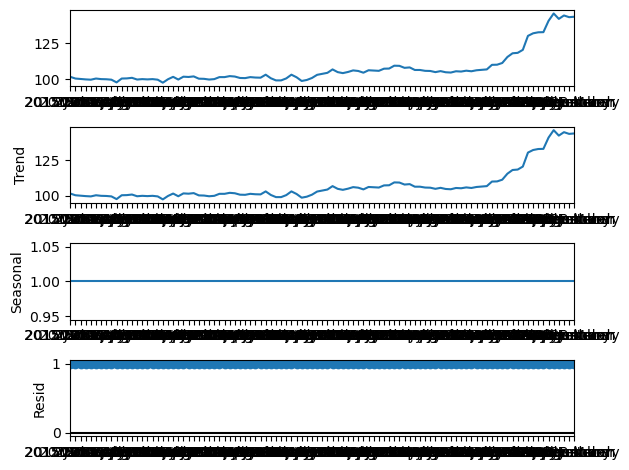

In [718]:
decompose_result = seasonal_decompose(holts_df ,model='multiplicative', period = 1)
decompose_result.plot();

In [733]:
m = 12
alpha = 1/(2*m)

#### Single HWSE

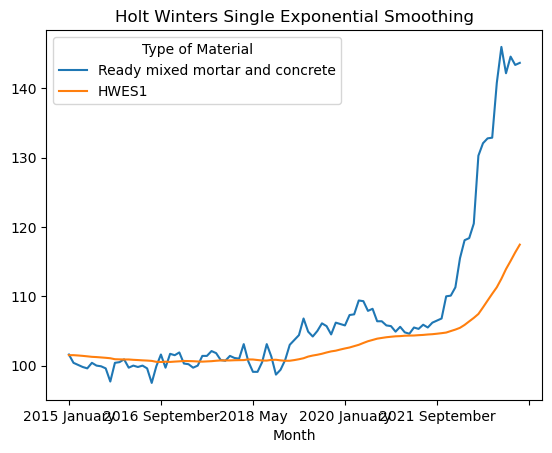

In [763]:
holts_df['HWES1'] = SimpleExpSmoothing(holts_df).fit(smoothing_level=alpha, optimized=True, use_brute=True).fittedvalues
holts_df[['Ready mixed mortar and concrete','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');       

#### Double HWSE

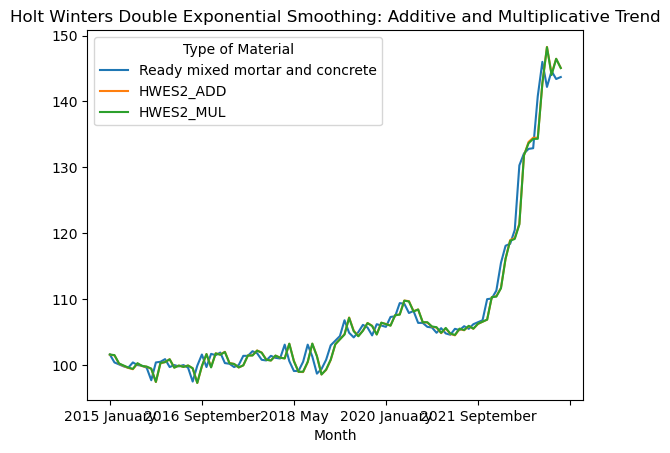

In [780]:
holts_df['HWES2_ADD'] = ExponentialSmoothing(holts_df['Ready mixed mortar and concrete'], trend='add').fit().fittedvalues

holts_df['HWES2_MUL'] = ExponentialSmoothing(holts_df['Ready mixed mortar and concrete'], trend='mul').fit().fittedvalues

holts_df[['Ready mixed mortar and concrete','HWES2_ADD', 'HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');         


#### Triple HWSE

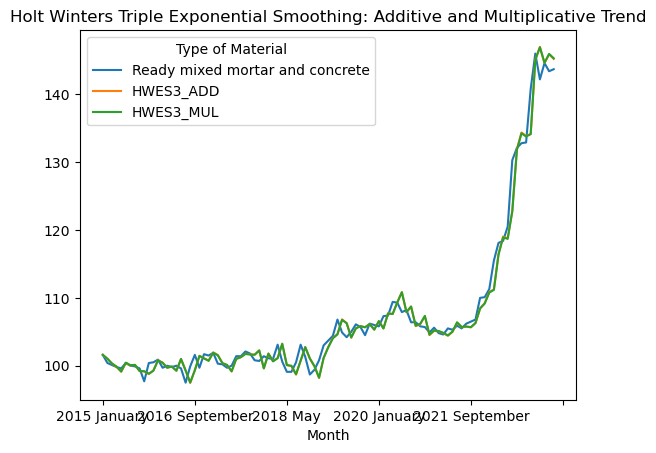

In [781]:
holts_df['HWES3_ADD'] = ExponentialSmoothing(holts_df['Ready mixed mortar and concrete'], trend='add', seasonal='mul',seasonal_periods=12).fit().fittedvalues

holts_df['HWES3_MUL'] = ExponentialSmoothing(holts_df['Ready mixed mortar and concrete'], trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues

holts_df[['Ready mixed mortar and concrete','HWES3_ADD', 'HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Trend');         


In [811]:
fitted_model = ExponentialSmoothing(train['Ready mixed mortar and concrete'], trend='mul', seasonal='mul',seasonal_periods=3).fit()
test_predictions = fitted_model.forecast(steps = 19)

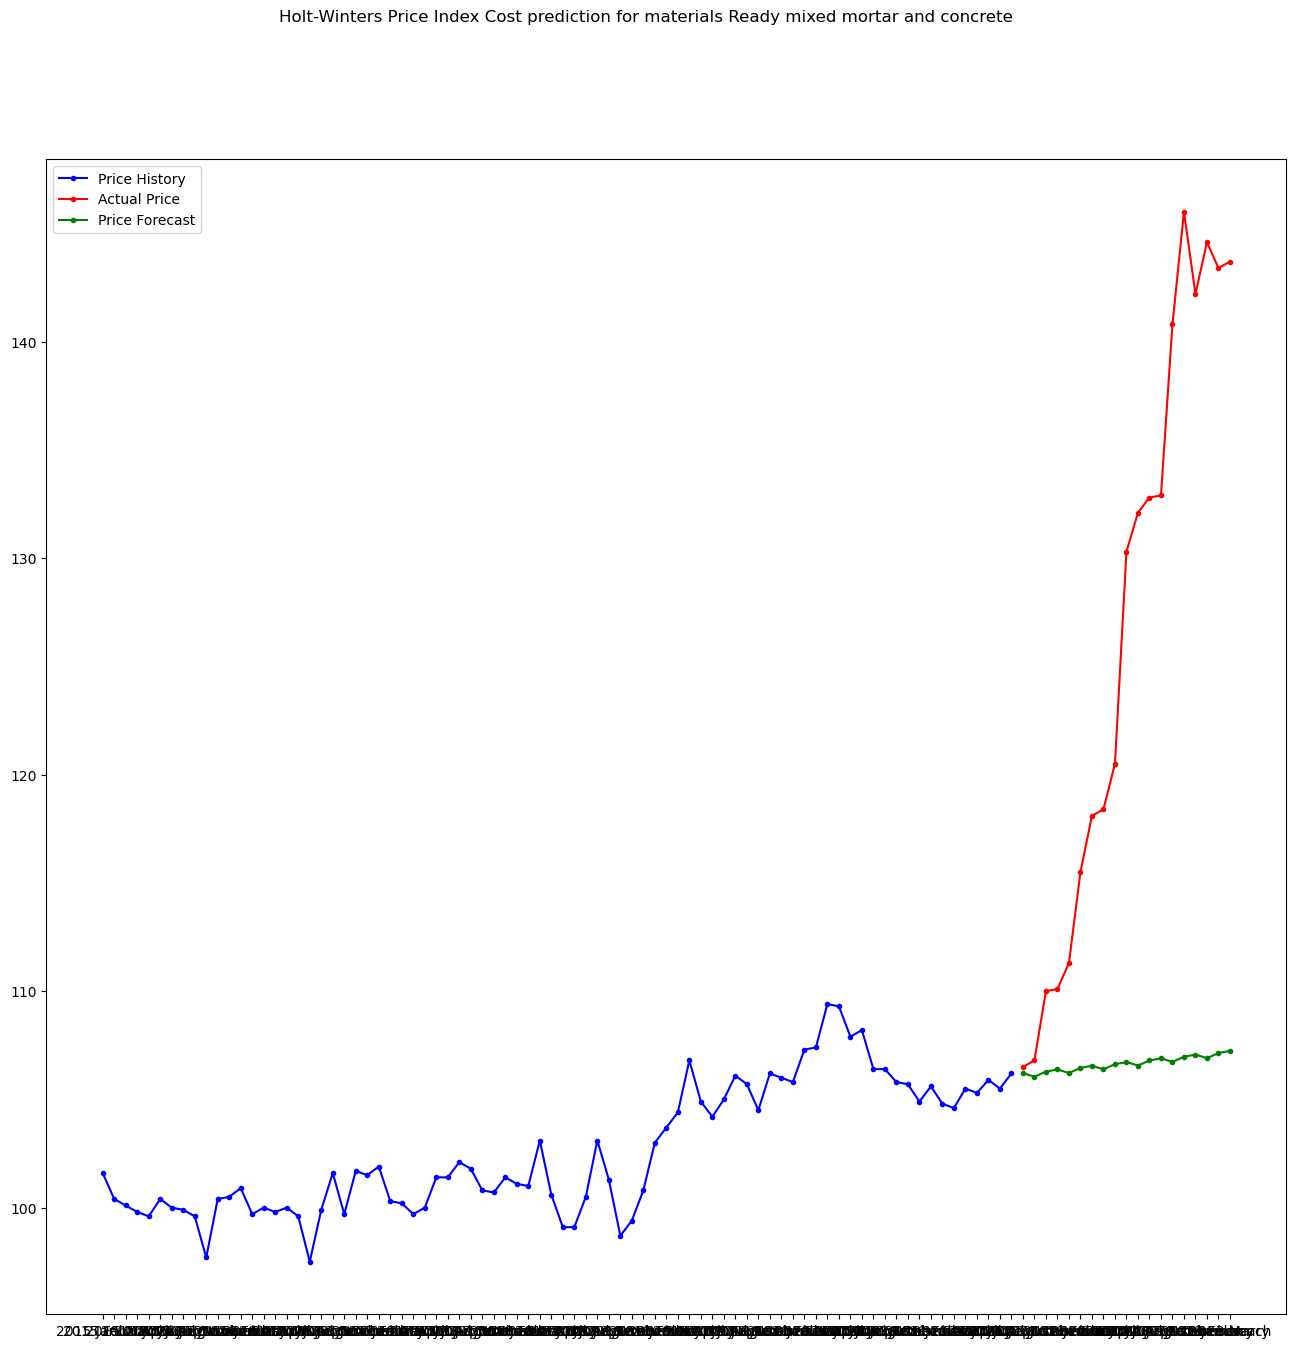

In [812]:
# Plot the training data, the test data and the forecast on the same plot.
fig = plt.figure(figsize = (16, 15))
fig.suptitle('Holt-Winters Price Index Cost prediction for materials Ready mixed mortar and concrete')


past, = plt.plot(train.index, train, 'b.-', label = 'Price History')
future, = plt.plot(test.index, test, 'r.-', label = 'Actual Price')
predicted_future, = plt.plot(test.index, test_predictions, 'g.-', label = 'Price Forecast')

plt.legend(handles = [past, future, predicted_future])
plt.show()

### Dashboard

In [828]:
# !pip install dash
# !pip install Flask==2.1.0
# !pip install jupyter-dash

In [829]:
import dash
from dash import dcc
from dash import html

In [833]:
from jupyter_dash import JupyterDash

In [847]:
df = new_ie_df
available_indicators = df.columns
df

Type of Material  Cement  Sand and gravel  Ready mixed mortar and concrete  \
Month                                                                        
2015 January       100.0             98.0                            101.6   
2015 February      100.0             96.1                            100.4   
2015 March         100.0             97.5                            100.1   
2015 April         100.0            106.2                             99.8   
2015 May           100.0            103.1                             99.6   
...                  ...              ...                              ...   
2022 November      168.6            131.1                            146.0   
2022 December      168.6            133.0                            142.2   
2023 January       168.6            131.0                            144.6   
2023 February      168.6            128.7                            143.4   
2023 March         168.6            120.9                            143.7   

Type of Material  Concrete blocks and bricks  \
Month                                          
2015 January                           100.2   
2015 February                          100.6   
2015 March                              99.0   
2015 April                              99.3   
2015 May                                99.4   
...                                      ...   
2022 November                          128.7   
2022 December                          129.6   
2023 January                           129.2   
2023 February                          130.0   
2023 March                             131.5   

Type of Material  Other concrete products including precast  \
Month                                                         
2015 January                                           99.2   
2015 February                                          99.3   
2015 March                                             99.3   
2015 April                                             99.3   
2015 May                                               99.7   
...                                                     ...   
2022 November                                         128.1   
2022 December                                         128.9   
2023 January                                          129.9   
2023 February                                         129.9   
2023 March                                            129.9   

Type of Material  Structural steel fabricated metal  Reinforcing metal  \
Month                                                                    
2015 January                                   97.3              100.7   
2015 February                                  97.3              100.9   
2015 March                                     97.9              100.8   
2015 April                                     99.3              100.6   
2015 May                                       99.3              100.4   
...                                             ...                ...   
2022 November                                 207.7              190.5   
2022 December                                 207.7              188.3   
2023 January                                  229.9              174.8   
2023 February                                 229.9              173.2   
2023 March                                    229.9              170.6   

Type of Material  Rough timber (including plain sawn)  \
Month                                                   
2015 January                                     99.5   
2015 February                                    99.9   
2015 March                                      100.0   
2015 April                                      100.0   
2015 May                                        100.0   
...                                               ...   
2022 November                                   155.7   
2022 December                                   154.5   
2023 Ja

In [1001]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

df_options = ['new_ie_df', 'new_uk_df']

new_ie_df = new_ie_df
new_uk_df = new_uk_df
available_indicators = new_ie_df.columns

# HTML entities
df_options_dropdown = html.Div([
    dcc.Dropdown(
        id='df_options_dropdown',
        options=[{'label': x, 'value': x} for x in df_options],
        value='new_ie_df'
    )])
material_dropdown = html.Div([
    dcc.Dropdown(
        id='material_dropdown',
        options=[{'label': x, 'value': x} for x in available_indicators],
        value='Ready mixed mortar and concrete'
    )])

# Where the figures will be displayed
fig_plot = html.Div(dcc.Graph(id='graph-content'))

@app.callback(
    dash.dependencies.Output('material_dropdown', 'options'),
    [dash.dependencies.Input('df_options_dropdown', 'value')])
def update_dropdown_options(value):
    if str(value) == str(new_ie_df):
        available_indicators = new_ie_df.columns
        print(available_indicators.to_list())
        return available_indicators.to_list()
    if str(value) == str(new_uk_df):
        available_indicators = new_uk_df.columns
        print(available_indicators.to_list())
        return available_indicators.to_list()

app.layout = html.Div([df_options_dropdown, material_dropdown, fig_plot])

# Create server variable with Flask server object for use with gunicorn
server = app.server

In [1002]:
app.run_server(mode="inline")

Dash is running on http://127.0.0.1:8050/



In [976]:
new_ie_df

Type of Material  Cement  Sand and gravel  Ready mixed mortar and concrete  \
Month                                                                        
2015 January       100.0             98.0                            101.6   
2015 February      100.0             96.1                            100.4   
2015 March         100.0             97.5                            100.1   
2015 April         100.0            106.2                             99.8   
2015 May           100.0            103.1                             99.6   
...                  ...              ...                              ...   
2022 November      168.6            131.1                            146.0   
2022 December      168.6            133.0                            142.2   
2023 January       168.6            131.0                            144.6   
2023 February      168.6            128.7                            143.4   
2023 March         168.6            120.9                            143.7   

Type of Material  Concrete blocks and bricks  \
Month                                          
2015 January                           100.2   
2015 February                          100.6   
2015 March                              99.0   
2015 April                              99.3   
2015 May                                99.4   
...                                      ...   
2022 November                          128.7   
2022 December                          129.6   
2023 January                           129.2   
2023 February                          130.0   
2023 March                             131.5   

Type of Material  Other concrete products including precast  \
Month                                                         
2015 January                                           99.2   
2015 February                                          99.3   
2015 March                                             99.3   
2015 April                                             99.3   
2015 May                                               99.7   
...                                                     ...   
2022 November                                         128.1   
2022 December                                         128.9   
2023 January                                          129.9   
2023 February                                         129.9   
2023 March                                            129.9   

Type of Material  Structural steel fabricated metal  Reinforcing metal  \
Month                                                                    
2015 January                                   97.3              100.7   
2015 February                                  97.3              100.9   
2015 March                                     97.9              100.8   
2015 April                                     99.3              100.6   
2015 May                                       99.3              100.4   
...                                             ...                ...   
2022 November                                 207.7              190.5   
2022 December                                 207.7              188.3   
2023 January                                  229.9              174.8   
2023 February                                 229.9              173.2   
2023 March                                    229.9              170.6   

Type of Material  Rough timber (including plain sawn)  \
Month                                                   
2015 January                                     99.5   
2015 February                                    99.9   
2015 March                                      100.0   
2015 April                                      100.0   
2015 May                                        100.0   
...                                               ...   
2022 November                                   155.7   
2022 December                                   154.5   
2023 Ja

In [844]:
df = pd.read_csv('https://plotly.github.io/datasets/country_indicators.csv')
available_indicators = df['Indicator Name'].unique()
df

Country Name                                     Indicator Name  Year  \
0       Arab World                Agriculture, value added (% of GDP)  1962   
1       Arab World             CO2 emissions (metric tons per capita)  1962   
2       Arab World  Domestic credit provided by financial sector (...  1962   
3       Arab World        Electric power consumption (kWh per capita)  1962   
4       Arab World       Energy use (kg of oil equivalent per capita)  1962   
...            ...                                                ...   ...   
36955     Zimbabwe                   Industry, value added (% of GDP)  2007   
36956     Zimbabwe                 Inflation, GDP deflator (annual %)  2007   
36957     Zimbabwe            Life expectancy at birth, total (years)  2007   
36958     Zimbabwe  Population density (people per sq. km of land ...  2007   
36959     Zimbabwe             Services, etc., value added (% of GDP)  2007   

           Value  
0            NaN  
1       0.760996  
2      18.168690  
3            NaN  
4            NaN  
...          ...  
36955  33.074953  
36956   0.894887  
36957  44.177756  
36958  34.374559  
36959  45.327139  

[36960 rows x 4 columns]

In [845]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# Create server variable with Flask server object for use with gunicorn
server = app.server

app.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Dropdown(
                id='crossfilter-xaxis-column',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='Ready mixed mortar and concrete'
            ),
            dcc.RadioItems(
                id='crossfilter-xaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                labelStyle={'display': 'inline-block'}
            )
        ],
        style={'width': '49%', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                id='crossfilter-yaxis-column',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='Life expectancy at birth, total (years)'
            ),
            dcc.RadioItems(
                id='crossfilter-yaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                labelStyle={'display': 'inline-block'}
            )
        ], style={'width': '49%', 'float': 'right', 'display': 'inline-block'})
    ], style={
        'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
        'padding': '10px 5px'
    }),

    html.Div([
        dcc.Graph(
            id='crossfilter-indicator-scatter',
            hoverData={'points': [{'customdata': 'Japan'}]}
        )
    ], style={'width': '49%', 'display': 'inline-block', 'padding': '0 20'}),
    html.Div([
        dcc.Graph(id='x-time-series'),
        dcc.Graph(id='y-time-series'),
    ], style={'display': 'inline-block', 'width': '49%'}),

    html.Div(dcc.Slider(
        id='crossfilter-year--slider',
        min=df['Year'].min(),
        max=df['Year'].max(),
        value=df['Year'].max(),
        marks={str(year): str(year) for year in df['Year'].unique()},
        step=None
    ), style={'width': '49%', 'padding': '0px 20px 20px 20px'})
])


@app.callback(
    dash.dependencies.Output('crossfilter-indicator-scatter', 'figure'),
    [dash.dependencies.Input('crossfilter-xaxis-column', 'value'),
     dash.dependencies.Input('crossfilter-yaxis-column', 'value'),
     dash.dependencies.Input('crossfilter-xaxis-type', 'value'),
     dash.dependencies.Input('crossfilter-yaxis-type', 'value'),
     dash.dependencies.Input('crossfilter-year--slider', 'value')])
def update_graph(xaxis_column_name, yaxis_column_name,
                 xaxis_type, yaxis_type,
                 year_value):
    dff = df[df['Year'] == year_value]

    return {
        'data': [dict(
            x=dff[dff['Indicator Name'] == xaxis_column_name]['Value'],
            y=dff[dff['Indicator Name'] == yaxis_column_name]['Value'],
            text=dff[dff['Indicator Name'] == yaxis_column_name]['Country Name'],
            customdata=dff[dff['Indicator Name'] == yaxis_column_name]['Country Name'],
            mode='markers',
            marker={
                'size': 25,
                'opacity': 0.7,
                'color': 'orange',
                'line': {'width': 2, 'color': 'purple'}
            }
        )],
        'layout': dict(
            xaxis={
                'title': xaxis_column_name,
                'type': 'linear' if xaxis_type == 'Linear' else 'log'
            },
            yaxis={
                'title': yaxis_column_name,
                'type': 'linear' if yaxis_type == 'Linear' else 'log'
            },
            margin={'l': 40, 'b': 30, 't': 10, 'r': 0},
            height=450,
            hovermode='closest'
        )
    }


def create_time_series(dff, axis_type, title):
    return {
        'data': [dict(
            x=dff['Year'],
            y=dff['Value'],
            mode='lines+markers'
        )],
        'layout': {
            'height': 225,
            'margin': {'l': 20, 'b': 30, 'r': 10, 't': 10},
            'annotations': [{
                'x': 0, 'y': 0.85, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(255, 255, 255, 0.5)',
                'text': title
            }],
            'yaxis': {'type': 'linear' if axis_type == 'Linear' else 'log'},
            'xaxis': {'showgrid': False}
        }
    }


@app.callback(
    dash.dependencies.Output('x-time-series', 'figure'),
    [dash.dependencies.Input('crossfilter-indicator-scatter', 'hoverData'),
     dash.dependencies.Input('crossfilter-xaxis-column', 'value'),
     dash.dependencies.Input('crossfilter-xaxis-type', 'value')])
def update_y_timeseries(hoverData, xaxis_column_name, axis_type):
    country_name = hoverData['points'][0]['customdata']
    dff = df[df['Country Name'] == country_name]
    dff = dff[dff['Indicator Name'] == xaxis_column_name]
    title = '<b>{}</b><br>{}'.format(country_name, xaxis_column_name)
    return create_time_series(dff, axis_type, title)


@app.callback(
    dash.dependencies.Output('y-time-series', 'figure'),
    [dash.dependencies.Input('crossfilter-indicator-scatter', 'hoverData'),
     dash.dependencies.Input('crossfilter-yaxis-column', 'value'),
     dash.dependencies.Input('crossfilter-yaxis-type', 'value')])
def update_x_timeseries(hoverData, yaxis_column_name, axis_type):
    dff = df[df['Country Name'] == hoverData['points'][0]['customdata']]
    dff = dff[dff['Indicator Name'] == yaxis_column_name]
    return create_time_series(dff, axis_type, yaxis_column_name)

In [846]:
app.run_server(mode="inline")

Dash is running on http://127.0.0.1:8050/

